# This notebook run code(s) on multiple animal/session/ for RAT Behavioral experiment

### This notebook is at the core of the pipeline of data processing. Do not play with it lightly inside the master folder (load_preprocess_rat)

#### 1. Only modifiy if you are sure of what you are doing and that you are solving a bug
#### 2. If you do modify you MUST commit this modification using bitbucket
#### 3. If you want to play whis notebook (to understand it better) copy it on a toy folder distinct from the master folder
#### 4. If you want to modify this code (fix bug, improve, add attributes ...) it is recommanded  to first duplicate in a draft folder. Try to keep track of your change.
#### 5. When you are ready to commit : # clear all output, clean everything between hashtag 



## 1. Load packages and define functions

In [3]:
#modules to find path of all sessions
import glob
import os
import numpy as np
from IPython.display import clear_output, display, HTML
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
#run other notebooks
## The lines below allow to run required notebook from the master folder
if "__file__" not in dir():
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    os.chdir(CommunNoteBookesPath)   
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb



# PARAMETERS (used if the pickles don't exist)
param={
    "goalTime":7,#needed for pavel data only
    "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
    "maxTrialDuration":20,
    "interTrialDuration":10,#None pavel
    "endTrial_frontPos":30,
    "endTrial_backPos":55, 
    "endTrial_minTimeSec":4,
    "cameraSamplingRate":25, #needed for new setup    

    "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
    "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
     "nbJumpMax":100,#200 pavel
    "binSize":0.25,
    #parameters used to preprocess (will override the default parameters)
}  

if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False    


def mode(a, axis=0):
    scores = np.unique(np.ravel(a))       # get ALL unique values
    testshape = list(a.shape)
    testshape[axis] = 1
    oldmostfreq = np.zeros(testshape)
    oldcounts = np.zeros(testshape)

    for score in scores:
        template = (a == score)
        counts = np.expand_dims(np.sum(template, axis),axis)
        mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
        oldcounts = np.maximum(counts, oldcounts)
        oldmostfreq = mostfrequent

    return mostfrequent, oldcounts

def compute_or_read_stats(data, saveAsPickle=True, pickleName="behaviorStats.p",redo=False):
    
        
    pathPickle=os.path.join(data.analysisPath,pickleName)
    if os.path.exists(pathPickle) and (not redo):
        with open(pathPickle,"rb") as f:
            result=pickle.load(f)
            return result    
    result={}
    
    
    
    #percentage of good trials
    result["% good trials"]=np.round(len(data.goodTrials)/float(data.nTrial) *100)
    
    #percentage of good trials in the 40 last trials
    last40GoodTrial=[trial for trial in data.goodTrials if trial>(data.nTrial-41)]
    
   
    
    
    result["% good trials on last 40"]=np.round(len(last40GoodTrial)/40.0 *100)
    
    #percentile entrance time
    realEntranceTimes=data.entranceTime[data.entranceTime<data.maxTrialDuration]
    if len(realEntranceTimes)>0:
        entranceTimeP=np.nanpercentile(realEntranceTimes,[10,25,50,75,90])
        result["percentile entrance time"]=entranceTimeP
    else:
        result["percentile entrance time"]=np.full(5,data.maxTrialDuration[0])
    
    
    #median and std of entrance time
    result["median entrance time (sec)"]=np.nanmedian(data.entranceTime)
    result["standard deviation of entrance time"]=np.nanstd(data.entranceTime)
    result["mean entrance time (sec)"]=np.nanmean(data.entranceTime)
    
    #median correlation trajectories
    #result["median correlation of trajectories"]=plot_correlation_position(data,onlyGood=True)
    
    #correlation entrance time
    result["spearman entrance time"]=plot_correlation_entrance_time(data)

  
    #proportion of time running forward
    print(data.experiment)
    areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=False,highSpeed=None)
    result["time running forward"]=areaUnderCurve
    
    #proportion of time running forward for good trials
    areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=True,highSpeed=None)
    result["timerunningforwardGoodTrials"]=areaUnderCurve
    
    #Forward Speed
    result["Forward Speed"]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=False)
    plt.close()
    
    #Forward Speed vs TreadmillSpeed
    result["Forward Speed Vs TreadmillSpeed"]=plot_mean_forwardSpeedVsTreadmillSpeed(data,smoothSpeed=0.3,onlyGood=False)
    
    #Forward Speed for good trials
    result["Forward Speed good trials"]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=True)
    plt.close()
    
    #Tortuosity  and StraightSpeedForward
    SessionTortuosity,SessionStraightSpeed=plot_Tortuosity(data, onlyGood=False)
    plt.close()
    result["Tortuosity"]=SessionTortuosity
    result["Straight Speed Forward"]=SessionStraightSpeed
    
    #Trajectory Correlation
    SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=False,raw=False)
    plt.close()
    result["Trajectory Correlation"]=SessionCorrelationTrajectory
    
    
    
    #Trajectory Correlation for good trials
    SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=True,raw=False)
    plt.close()
    result["Trajectory Correlation good trials"]=SessionCorrelationTrajectory
    
    #Std from goaltime
    result["Std from goaltime"]=std_from_goaltime(data)
    
    
    if saveAsPickle:
        with open(pathPickle, 'wb') as f:
            pickle.dump(result, f)
    return result



def plot_learningCurves(root,animal,PerfParamToPlot,parameter={},stop_date="",tagList=[],redoPreprocess=False, redoStat=False,plot=True,PrintWarning=False):
    results={}
    days=[]
    colo=[]
    indexSession=[]
    errorSession=[]
    s=""
    for tag in tagList:
        s=s+tag  # question of david: what is this s? 
    
    
    AnimalTagPath=os.path.join(root,animal,"Tag")
    if os.path.isfile(AnimalTagPath): 
            fileTag = open(root+"/"+animal+"/Tag", "r")
            AnimalTag = fileTag.read()
    else:
        AnimalTag="no tag"
    
    
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
    sessionList=sorted(sessionList)
    #print(sessionList)
    
    
    if stop_date!="":
        stop_session = [os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/"+animal+stop_date+"*")]
        if PrintWarning:
            print(stop_session)
        indexSession= sessionList.index(stop_session[0])
        del sessionList[indexSession:]
    
    
    res_TS =[]
    #loop through sessions
    for session in sessionList:  
        if PrintWarning:
            print("--------")
            print(session)
        if len(tagList)>0:
            if not has_tag(root, animal, session, tagList):
                    continue
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        try:
            sessionData=Data(root,animal,session,parameter,redoPreprocess=redoPreprocess)
        except Exception as e:
            if PrintWarning:
                display(HTML("<b> An error happened, skip session. Error message: </b>"))
                display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
                print("--------")
            errorSession.append(session)
            
            continue
        #---skip if file "NotToAnalyze"
        
        
        try:
            if "NotToAnalyze" in sessionData.emptyAnalysisFiles:
                if PrintWarning:
                    print("Not to analyze, skipped")
                    print("--------")
                continue 
        except:
            continue
           
        #print(sessionData.hasBehavior)
        if not sessionData.hasBehavior:
            continue
        try :
            et=sessionData.entranceTime 
        except:
            if PrintWarning:
                print('No entrance time, skipped')
                print("--------")
            continue   
        #skip if training data or no break time
        if (not sessionData.hasBehavior):
            if PrintWarning:
                print("No Behavior, skipped")
                print("--------")
            continue
        
        days.append(sessionData.daySinceStart)
        if (sessionData.hasSpike) or (glob.glob(sessionData.fullPath+".dat")):
            colo.append("red")
        else:
            colo.append("black")
        
        #Compute a bench of Performance Parameters using a dedicated function
        res=compute_or_read_stats(sessionData,redo=redoStat)
        #davdebug
        
        
        #adding treadmill speed to res
        uniqueTreadSpeed=np.unique(sessionData.treadmillSpeed)
        if len(uniqueTreadSpeed)<len(sessionData.treadmillSpeed)*0.8:
            res["treadmillSpeed"]=mode(sessionData.treadmillSpeed)[0][0]
            #print(res["treadmillSpeed"])
        
        
        
#         res["treadmillSpeed"]=np.nanmedian(sessionData.treadmillSpeed)
#         print(session)
#         print("#####")
#       print(sessionData.treadmillSpeed)
        
        #adding goaltime speed to res.  In some rare cases goaltime is NaN is entrenace time was not written properly during data acquisition
        res["goaltime"]=np.unique(sessionData.goalTime[~np.isnan(sessionData.goalTime)])
        if len(res["goaltime"])>1:
            res["goaltime"]=np.median(res["goaltime"]) 
       
        
        
        if len(PerfParamToPlot)==0:
            PerfParamToPlot=list(res.keys())
            
        keys = list(res.keys())        
        for key in keys:
            try:
                results[key].append(res[key])
            except KeyError:
                results[key]=[res[key]]
                
    
    
    #clear_output()
    # One subplot for every key in results
    nbCol=2
    nbLine=len(PerfParamToPlot)//nbCol+len(PerfParamToPlot)%nbCol
    if plot:    
        fig=plt.figure(figsize=(15, 3*nbLine))
        #fig.subplots_adjust(hspace=1)
        for index,key in enumerate(sorted(PerfParamToPlot)):
            #print(index,key)
            ax=plt.subplot(nbLine,nbCol,index+1)
            if isinstance(results[key][0],(np.ndarray,list)):
                if key=="percentile entrance time":
                    med=[array[2] for array in results[key]]
                    lowestdist=[array[1] for array in results[key]]
                    higestdist=[array[-2] for array in results[key]]
                    lowError=[array[2]-array[1] for array in results[key]]
                    highError=[array[3]-array[2] for array in results[key]]
                    ax.errorbar(days,med,yerr=np.vstack([lowError,highError]),ls="",color='k')
                    colorNonan=[c for c,res in zip(colo,med) if not np.isnan(res)]
                    ax.scatter(days,med,c=colorNonan,zorder=10, s=20)
                    ax.plot(days,med,color="lightgrey",linewidth=2)
                    ymax=max(higestdist)
                    ymin=min(lowestdist)
                    key+=" (25% - 50% - 75%)"
                    ax.set_ylim([0,15])
                    ax.plot(days,results["goaltime"],color="red",linestyle='--')
            else:

                ax.plot(days,results[key],color="lightgrey",linewidth=2)
                colorNonan=[c for c,res in zip(colo,results[key]) if not np.isnan(res)]
                ax.scatter(days,results[key],c=colorNonan,zorder=10,s=20)
                ymax=max([x for x in results[key] if not isNone(x)])
                ymin=min([x for x in results[key] if not isNone(x)])
               
           
            ax.set_title(animal+" "+key)
            if key=="median entrance time (sec)":
                ax.set_ylim([0,10])
            if key=="treadmillSpeed":
                ax.set_ylim([0,35])
            if key=="Trajectory Correlation":
                ax.set_ylim([0,1])
            if key=="% good trials on last 40":
                ax.set_ylim([0,100])   
                plt.axhline(72.5,linestyle='--',color='red')
            if key=="Forward Speed Vs TreadmillSpeed":
                ax.set_ylim([1,5])
            if key=="Std from goaltime":
                ax.set_ylim([0,3])
            if key=="Tortuosity":
                ax.set_ylim([2,7])
                
            
            ax.set_xlabel("session day")
            ax.xaxis.grid(which='major')  

            major_ticks = np.arange(0, days[-1], 10)                                              
            minor_ticks = np.arange(0, days[-1], 2)                                               
            ax.set_xticks(major_ticks)                                                       
            #ax.set_xticks(minor_ticks, minor=True)
            ax.set_xlim([days[0]-1,days[-1]+1])
           

        plt.tight_layout()            
        plt.subplots_adjust(top=0.9)
        
        AllTreadmillSpeedsUsed=np.unique(results['treadmillSpeed'])
        SpeedInfoForTitle=''
        for TreadmillSpeedUsed in AllTreadmillSpeedsUsed:
            SpeedInfoForTitle += str(TreadmillSpeedUsed) +'-' 
            
        SpeedInfoForTitle=SpeedInfoForTitle[:-1]
        
        
        plt.suptitle(animal + ' (' + AnimalTag + '), trained at '+ SpeedInfoForTitle + 'cm/s',fontsize=16)

        #save plot
        animalAnalysisPath=os.path.join(root,animal,"Analysis")
        if not os.path.exists(animalAnalysisPath):
            os.mkdir(animalAnalysisPath)
 
        fullPathLearningCurves=os.path.join(animalAnalysisPath,"LearningCurves"+s+".png")
        plt.savefig(fullPathLearningCurves)
        LearningCurveName=os.path.basename(fullPathLearningCurves)

        
        #Insert the learning curves png figure in the general HTML page that shows behavioral performance session by session(all_behavior_plot.html)        
        nameGeneralHTML = "all_plot_session_behavior.html"
        pathGeneralHTML = os.path.join(animalAnalysisPath, nameGeneralHTML)
        LearningCurveImage= ["<a href=#%s><center><img src='%s' alt='%s' title='LearningAcrossSession'/></center></a>"%(animalAnalysisPath, LearningCurveName,fullPathLearningCurves)]#Line to add
        sessionData.remove_lines_in_html(pathGeneralHTML, LearningCurveName) #remove the old LearningAcrossSession.png if there is one...
        sessionData.insert_in_html(pathGeneralHTML, LearningCurveImage, nameGeneralHTML) #insert the new one at the end
        
        
        
    
    #save learning curve of all performance and task param in pickle 
    results["days"]=days
    # adding treadmill speed
    #results["treadmillSpeed"]=res_TS
    path=os.path.join(root,animal,"Analysis")
    if not os.path.exists(path):
            os.mkdir(path)
    path=os.path.join(path,"learningStats"+s+".p")
    

    with open(path, 'wb') as f:
        pickle.dump(results, f)
    if PrintWarning:
        print("Save pickle: %s"%path)

    if errorSession:
        if PrintWarning:
            display(HTML("<b> An error happened for the following session(s):"))
            print("\n".join(errorSession))
    return results



# below you can manual modify the root folder. Before commit or push remove anything between these line and leave 1 line blank

##############################

############################## 
    
print("path to data is %s"%root)
print("")
print("importing done")

path to data is /data

importing done


## Define animalList based on text files (lists)

In [59]:
if "__file__" not in dir():
    pathListsLocation=os.path.join(root,'ALLRAT_Analysis')
    pathListsLocation
    ListOfList= [os.path.basename(path) for path in sorted(glob.glob(pathListsLocation+"/Early*DLS"))]


    animalList=[]
    for thisList in ListOfList:
        FileName=os.path.join(pathListsLocation,thisList)
        with open(FileName) as f:
            content = f.readlines()
            content = [x.strip() for x in content]
            for animal in content:
                if len(animal)>0:
                    animalList.append(animal)

    print(animalList)

['Rat077', 'Rat078', 'Rat084', 'Rat095', 'Rat096', 'Rat098', 'Rat113', 'Rat079', 'Rat081', 'Rat082', 'Rat097', 'Rat099', 'Rat100', 'Rat114', 'Rat115', 'Rat116']


## Define animalList based on recently modified files on the NAS

In [5]:
if "__file__" not in dir():
    import datetime
    now=datetime.date.today()
    thisRoot="/NAS02"
    all_animals=[os.path.basename(path) for path in sorted(glob.glob(thisRoot+"/Rat*"))]
    last_modifTimes={}
    animalList=[]
    for animal in all_animals:
        experimentsPath=os.path.join(thisRoot,animal,"Experiments")
        if not os.path.exists(experimentsPath):
            continue

        sessionList=[os.path.basename(expPath) for expPath in glob.glob(thisRoot+"/"+animal+"/Experiments/Rat???_????_*")]
        if not sessionList:
            continue
        sessionList=sorted(sessionList)
        #print(animal)
        lastSessionDate= datetime.datetime.strptime(sessionList[-1][7:17],'%Y_%m_%d').date()
        if (now-lastSessionDate).days<=3:
            animalList.append(animal)
    print("Number of Animals: %s" %len(animalList))
    print(animalList)

Number of Animals: 33
['Rat085', 'Rat086', 'Rat088', 'Rat089', 'Rat091', 'Rat092', 'Rat095', 'Rat096', 'Rat097', 'Rat098', 'Rat099', 'Rat100', 'Rat101', 'Rat102', 'Rat103', 'Rat104', 'Rat106', 'Rat109', 'Rat110', 'Rat111', 'Rat112', 'Rat113', 'Rat114', 'Rat115', 'Rat116', 'Rat117', 'Rat118', 'Rat119', 'Rat120', 'Rat121', 'Rat122', 'Rat123', 'Rat124']


# Rsync from NAS02

In [55]:
if "__file__" not in dir():
    PathToSourceDataFolder="/NAS02/"
    PathToDestinationDataFolder=root
    RsyncArgument="rsync -auvrR "
    IncludeArgument="--include '*/' --include '*/*.position' --include '*/*.entrancetimes' --include '*/*.lickbreaktime' --include '*/*.behav_param'  --exclude '*' "
    os.chdir(PathToSourceDataFolder)
    for animal in sorted(animalList):
        print("in progress: " + RsyncArgument +  IncludeArgument + animal + " " + PathToDestinationDataFolder)
        os.system(RsyncArgument +  IncludeArgument + animal + " " + PathToDestinationDataFolder)
        sys.stdout.flush()
    clear_output()

## 2. Define animalList, the function(s) you want to run in batch and redo(s)

In [6]:
if "__file__" not in dir():
    #Example of animal list DO not changes the example below!!!
#     animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]  # all rats on your computer
#     animalList = ['Rat101', 'Rat102', 'Rat103', 'Rat104']
#     animalList = ['Rat075']

    #you can change animal list in between the hashtag 
    ###################

    ###################

    print("animals that will be analyzed: %s"%animalList)

    # this is where you define a list of functions you want to run on your data
    plotFunctionList=[plot_session_behavior]
    ###################

    ###################

    redo = True #redo basic preprocess and generate Data. Otherwise load from pickle 
    ###################
    redo = False
    ###################

    override = False #regenerate single session png figure. Otherwise use existing
    ###################
    override=False
    ###################
    replaceHtml=False #regenerate general HTML per animal. Otherwise use existing
    ###################
    replaceHtml=False
    ###################
    tagList=[] ## some session are tagged to be specifically analyzed versus time of lesion 
    ###################

    ###################

    PerfParamToPlot =["percentile entrance time","% good trials on last 40","median entrance time (sec)",
                 "Trajectory Correlation","Forward Speed Vs TreadmillSpeed","Tortuosity",'Std from goaltime']

    ###################

    ###################


animals that will be analyzed: ['Rat085', 'Rat086', 'Rat088', 'Rat089', 'Rat091', 'Rat092', 'Rat095', 'Rat096', 'Rat097', 'Rat098', 'Rat099', 'Rat100', 'Rat101', 'Rat102', 'Rat103', 'Rat104', 'Rat106', 'Rat109', 'Rat110', 'Rat111', 'Rat112', 'Rat113', 'Rat114', 'Rat115', 'Rat116', 'Rat117', 'Rat118', 'Rat119', 'Rat120', 'Rat121', 'Rat122', 'Rat123', 'Rat124']


In [8]:
plot_session_behavior.

## 3 - Loops through animals and session and functions

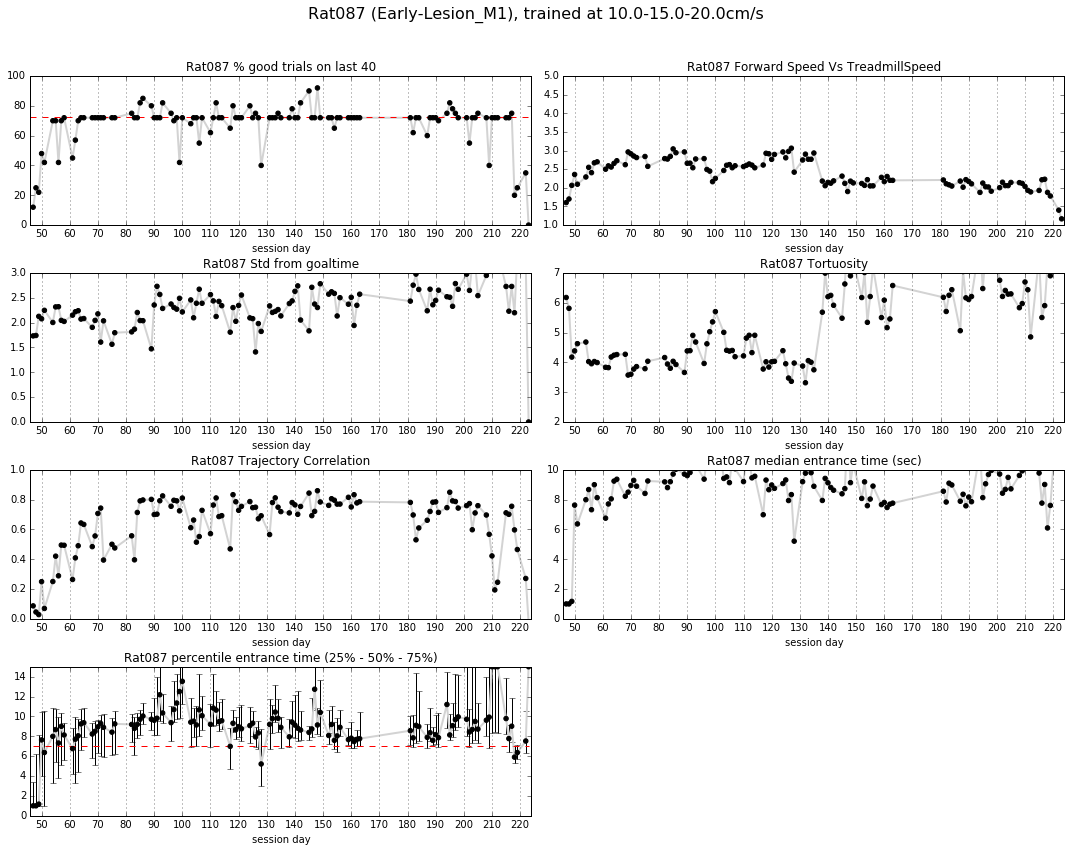

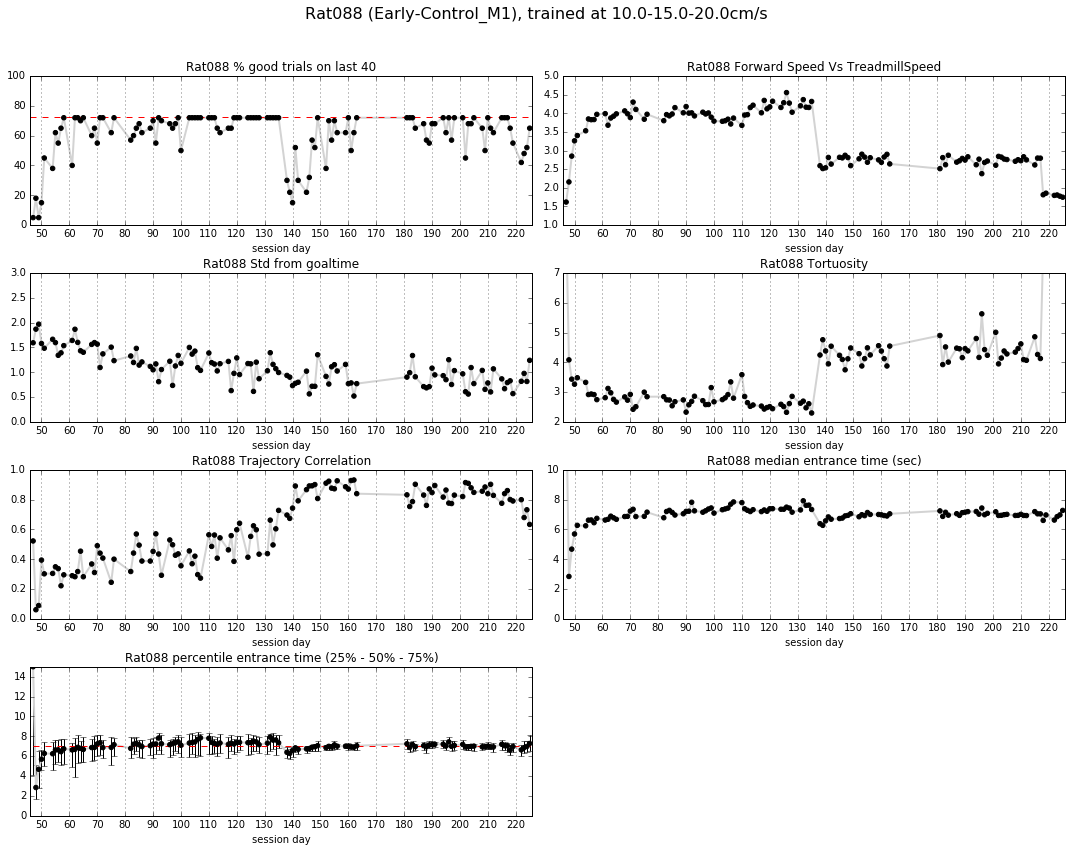

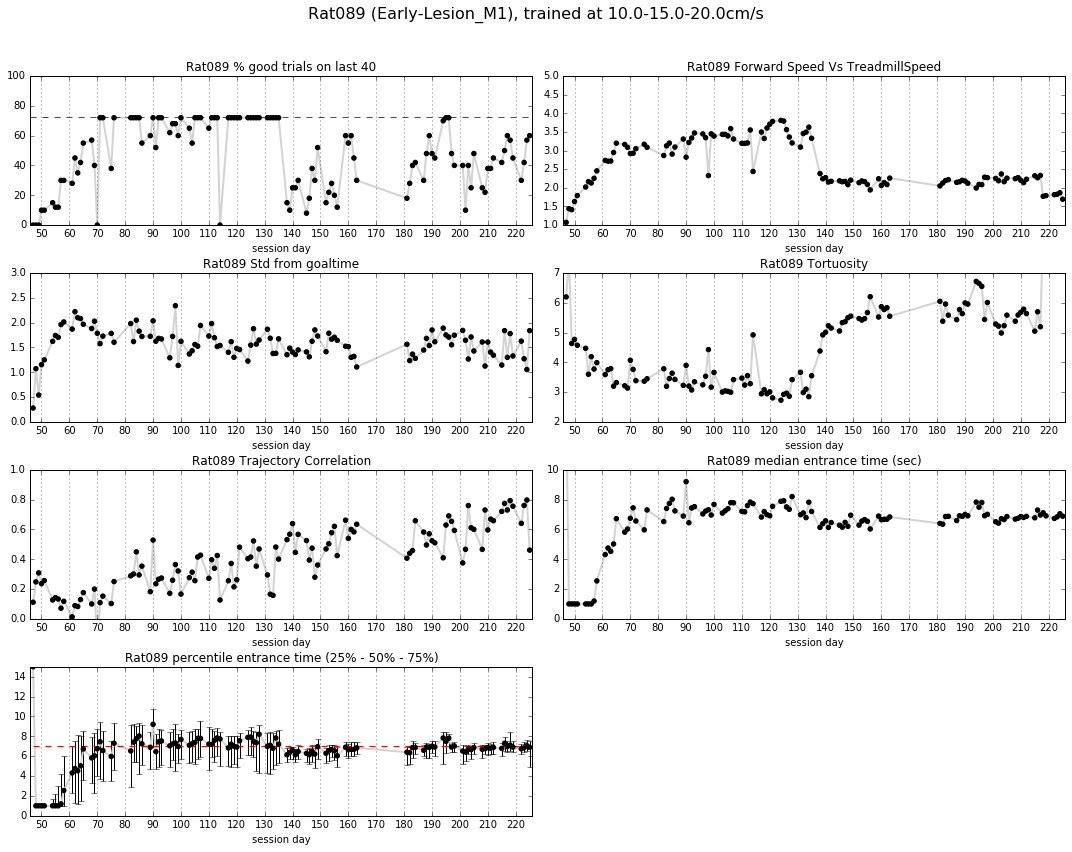

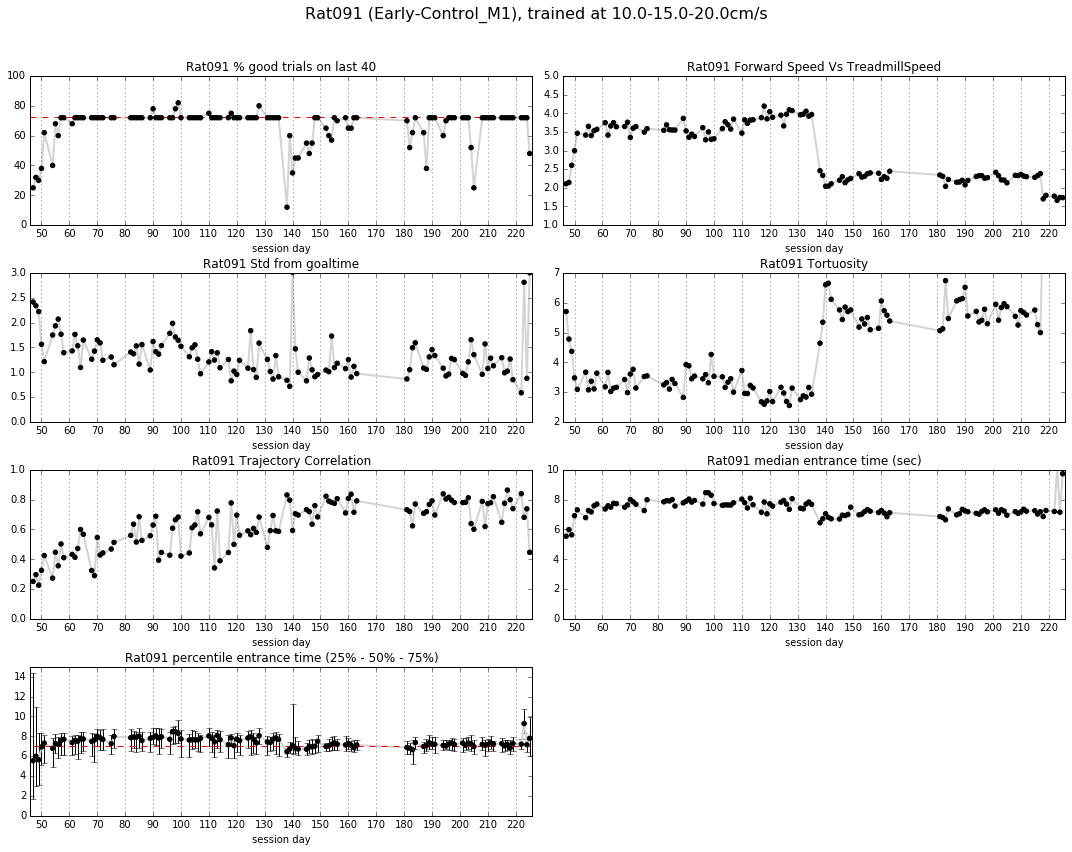

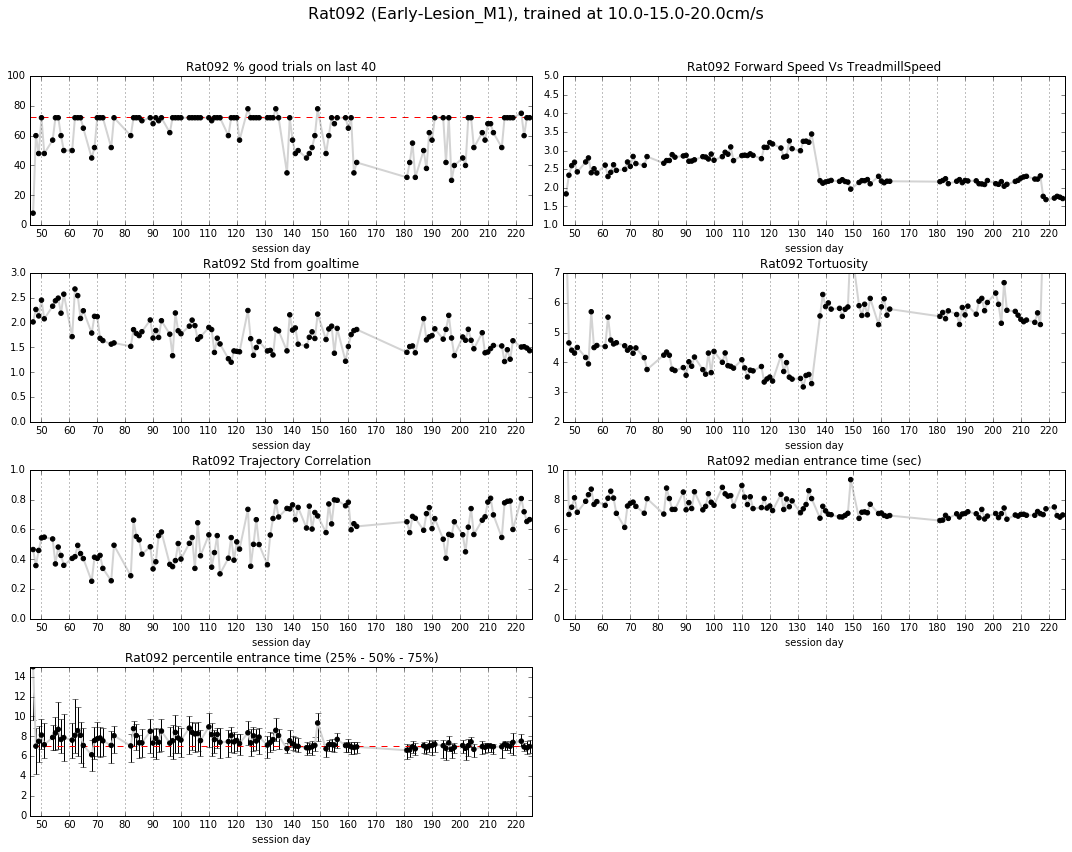

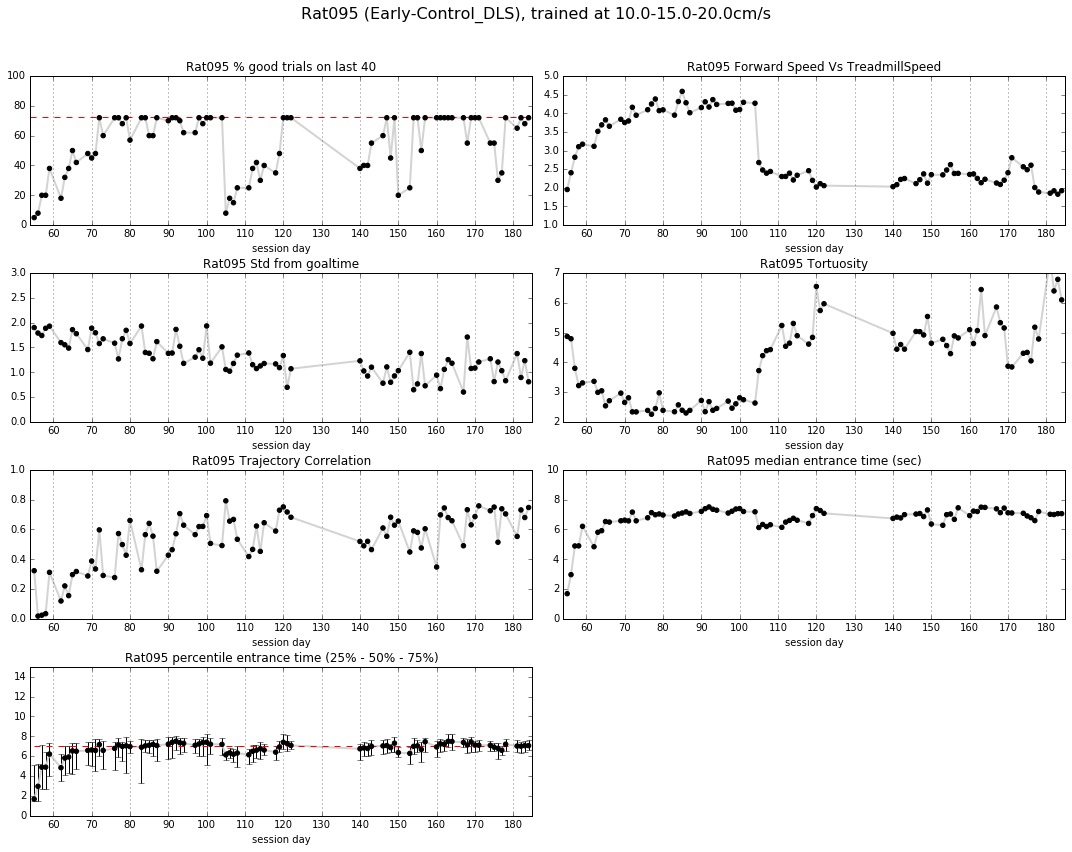

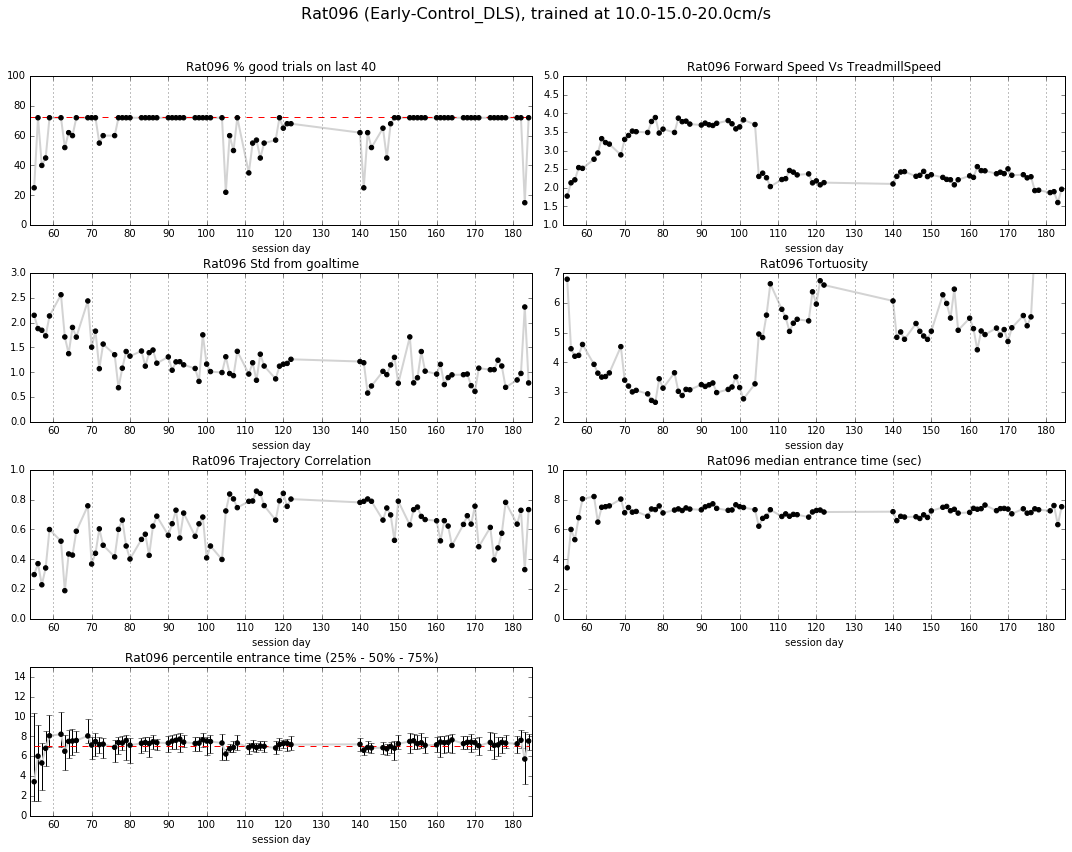

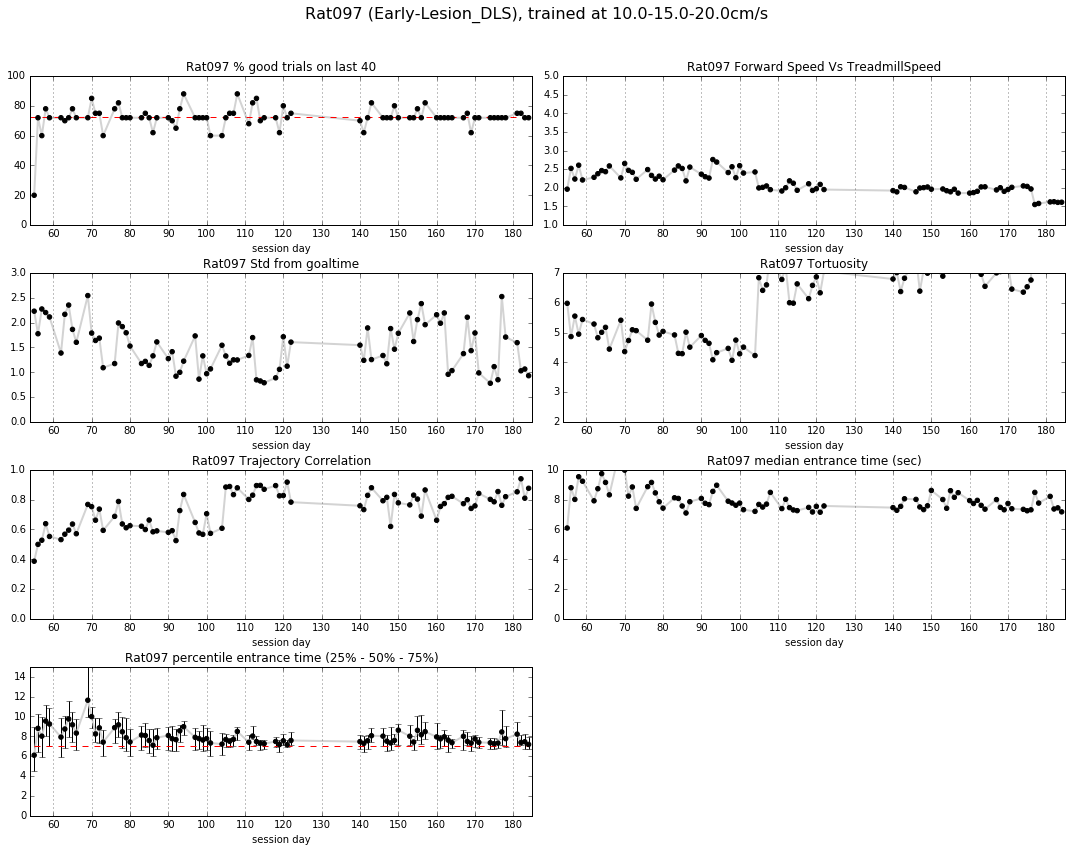

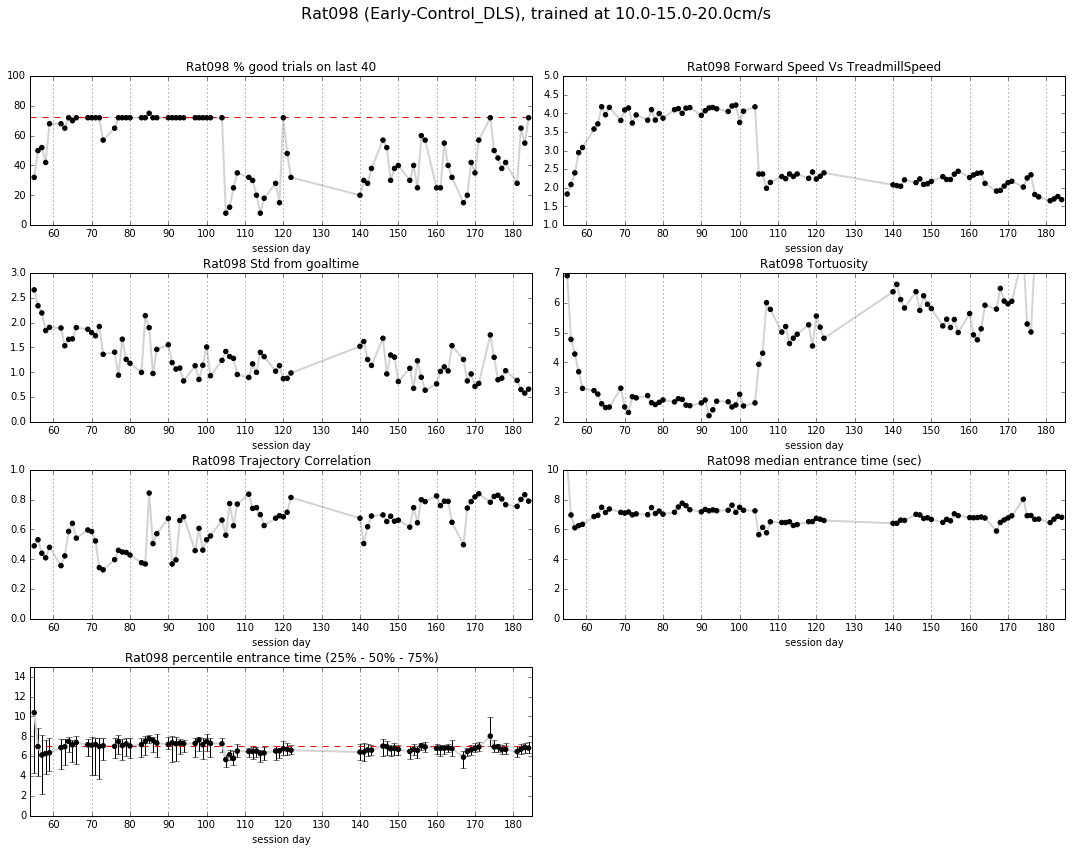

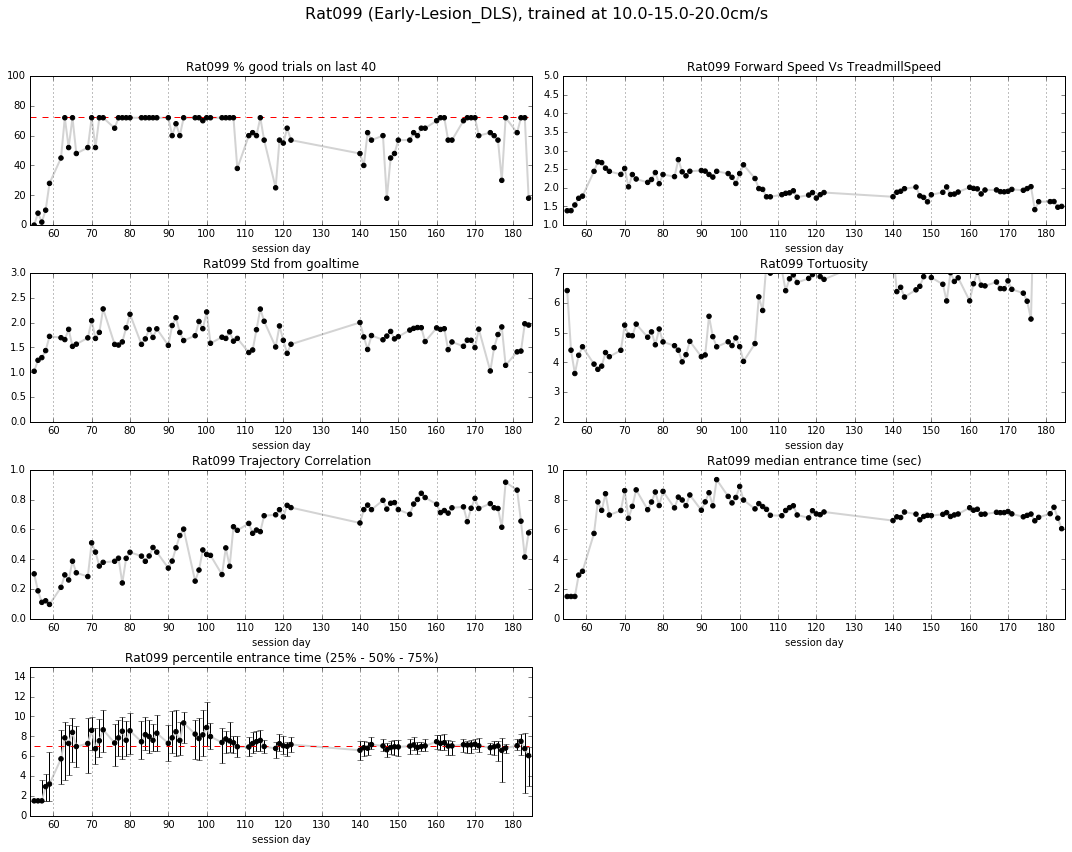

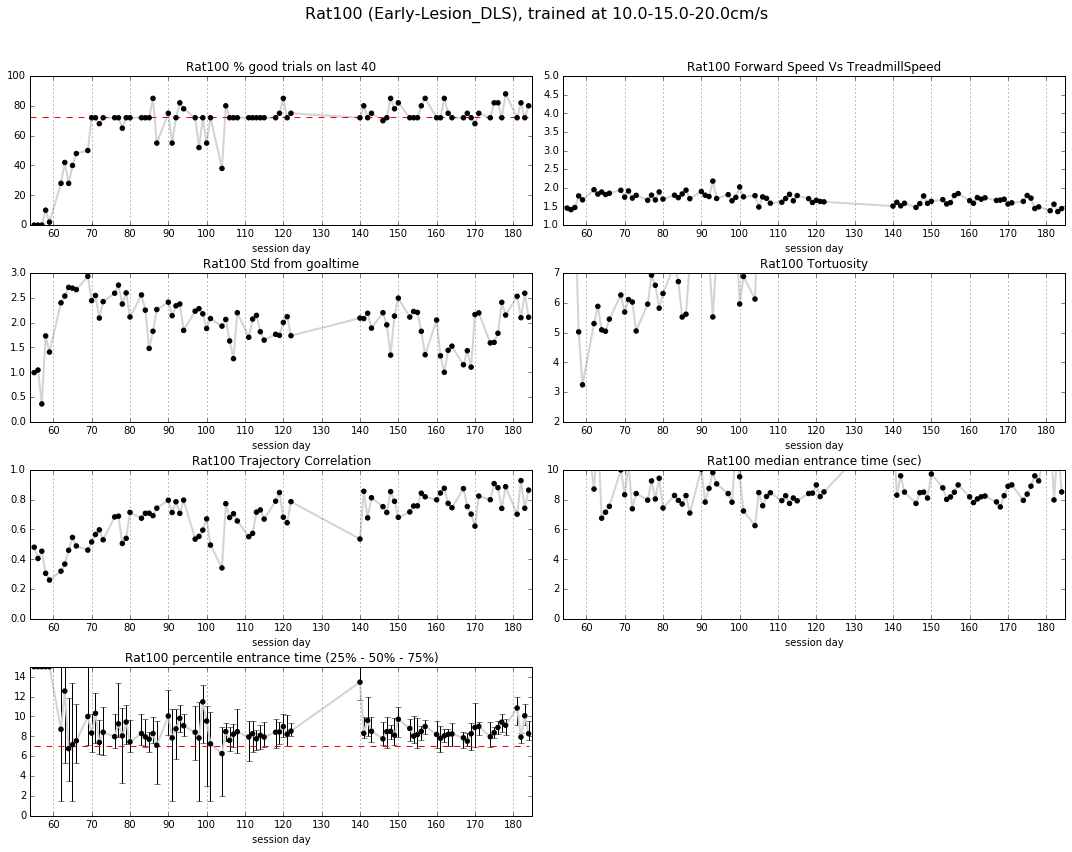

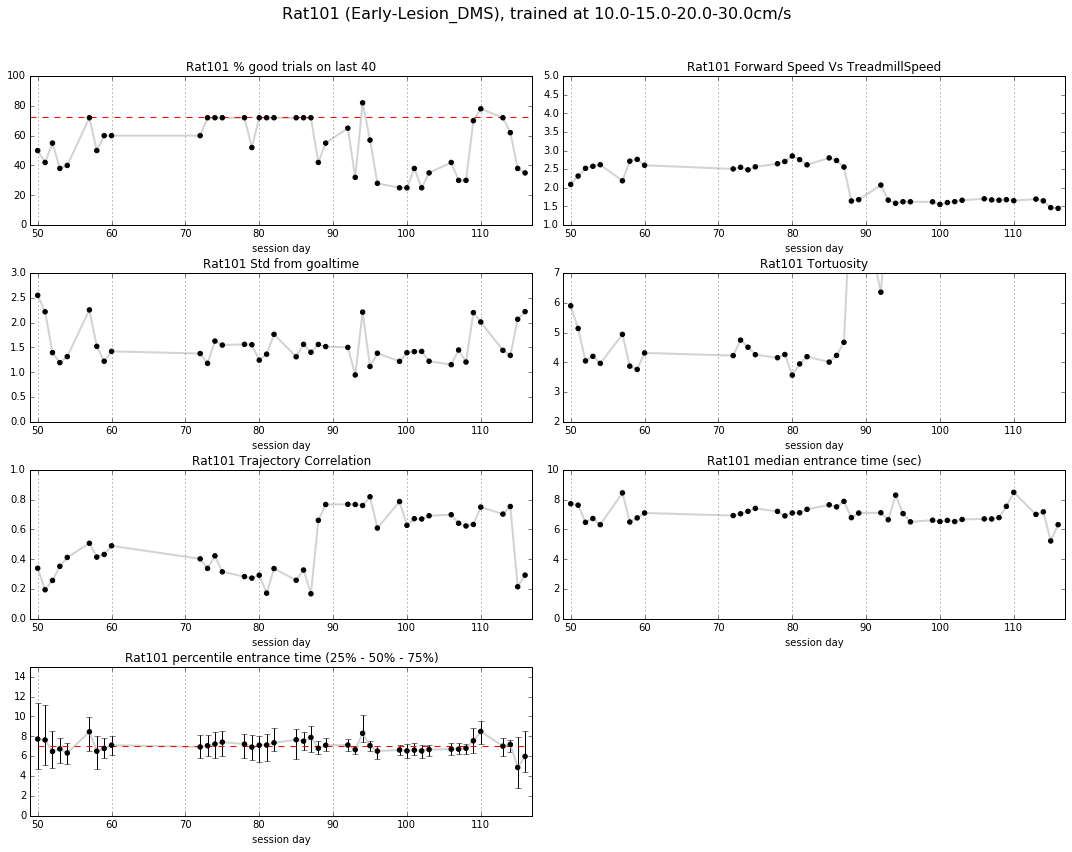

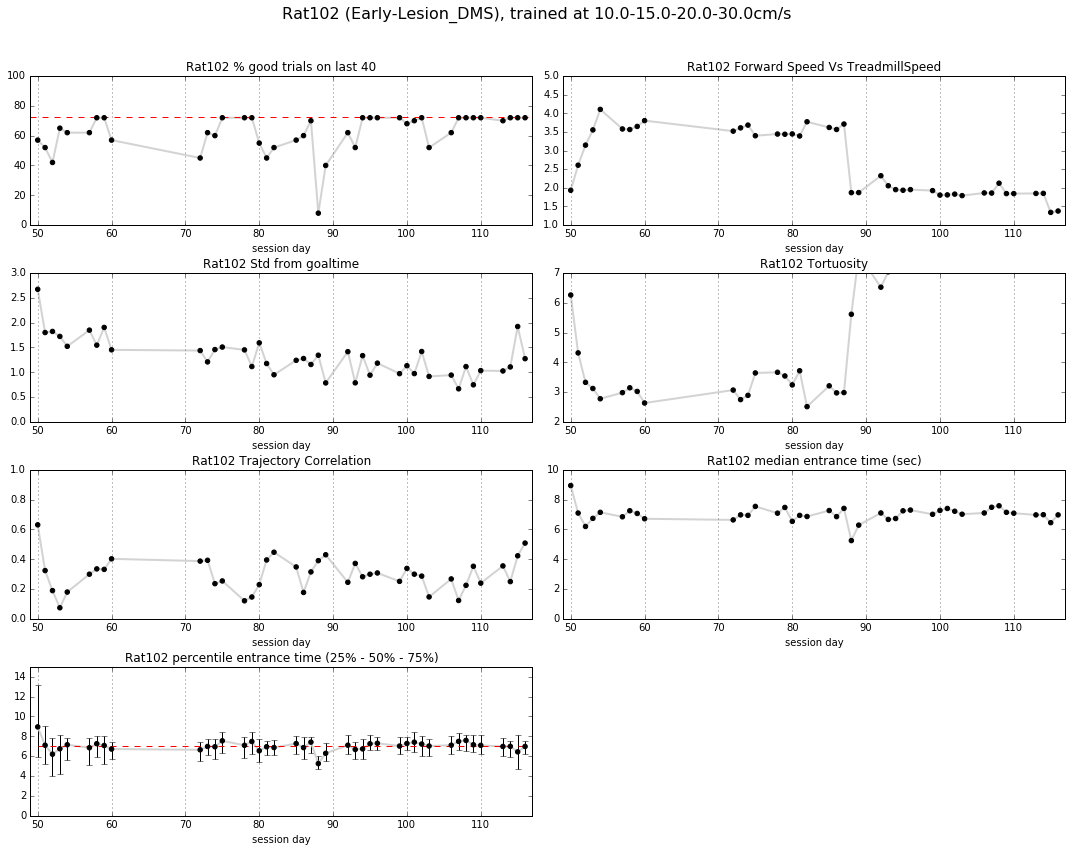

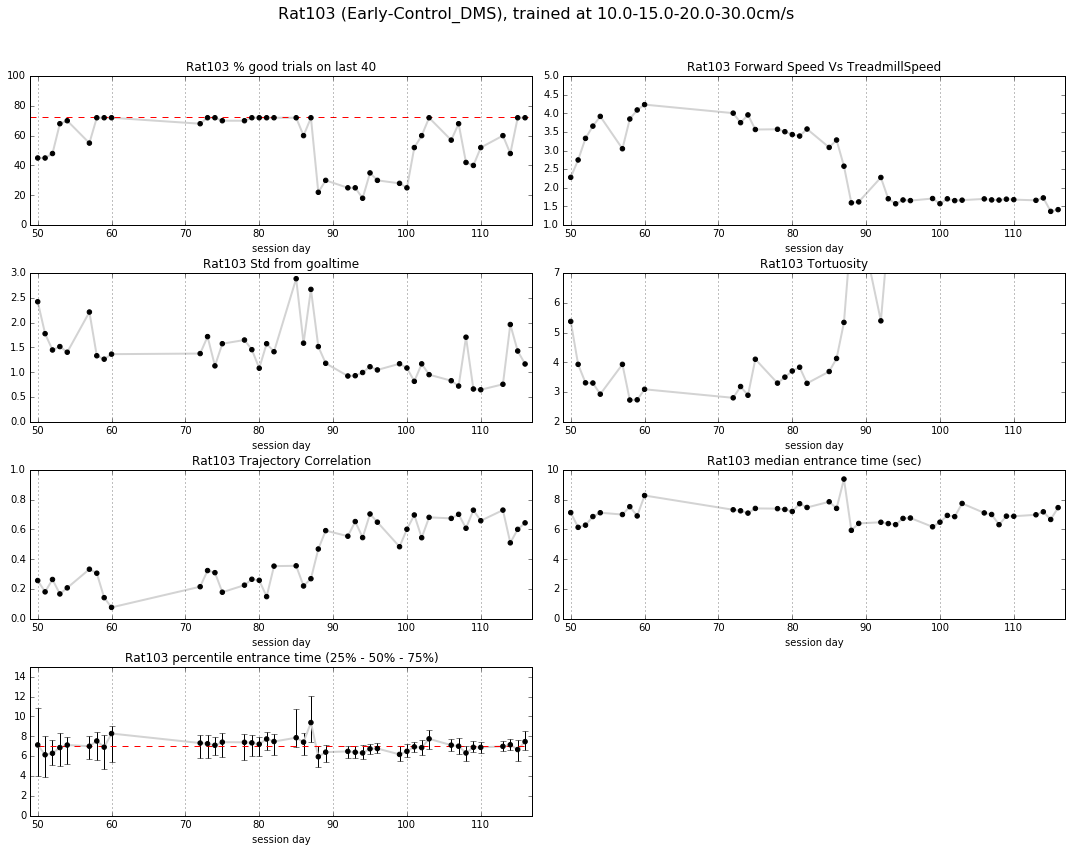

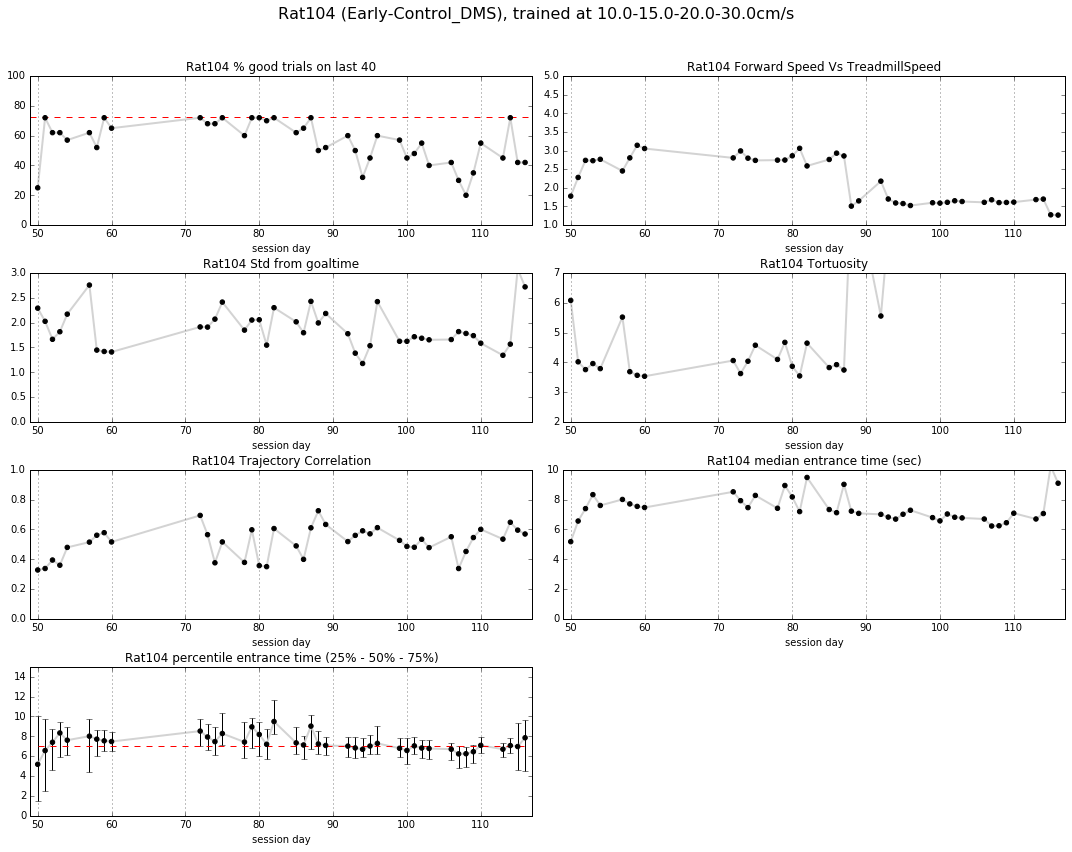

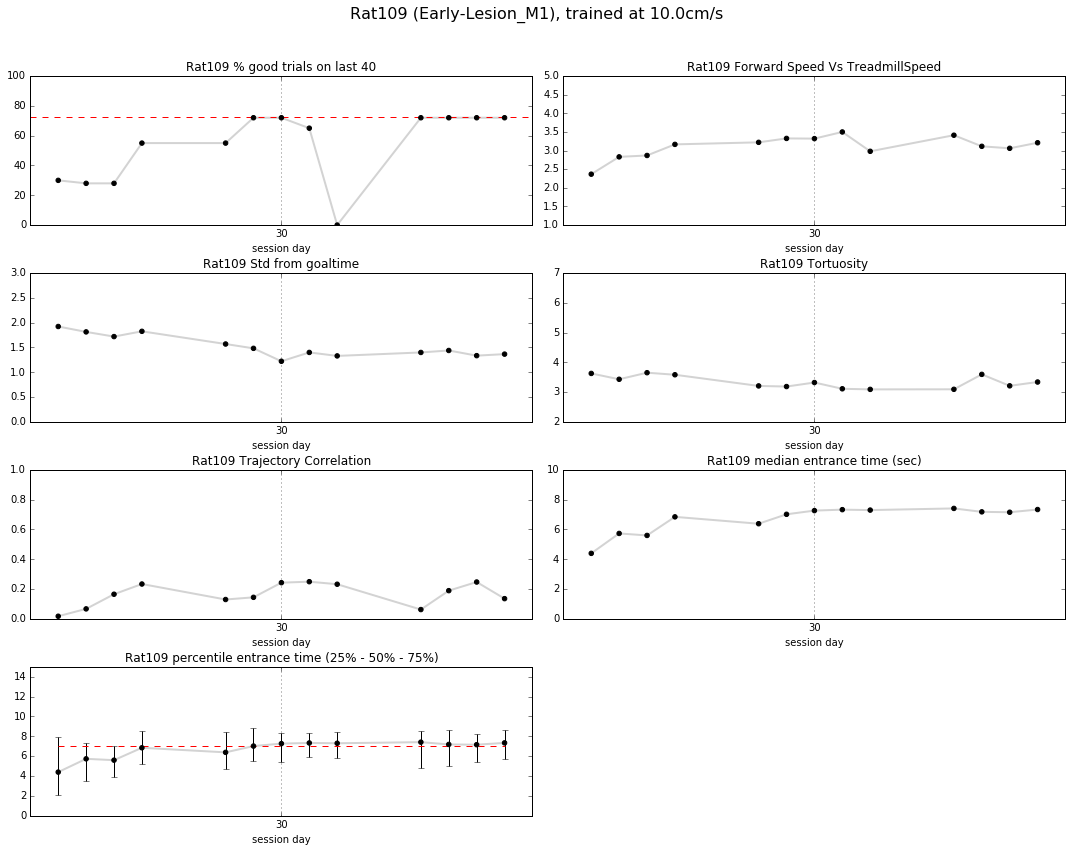

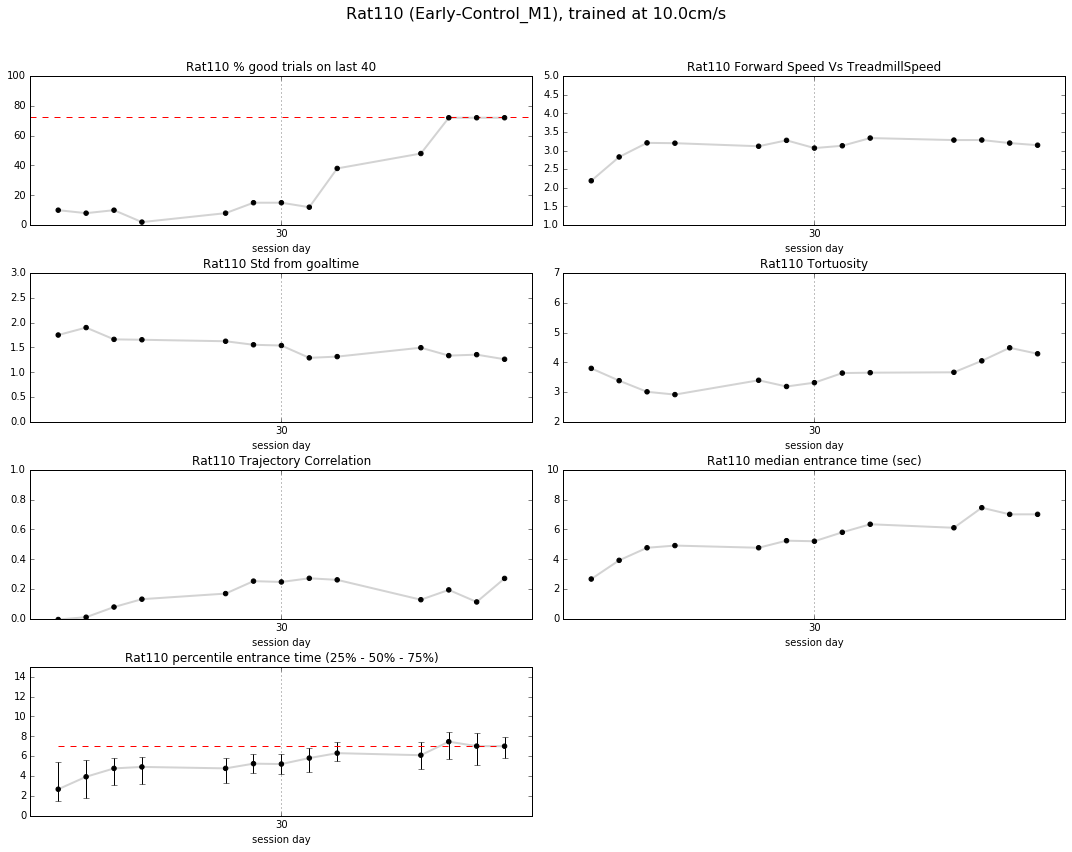

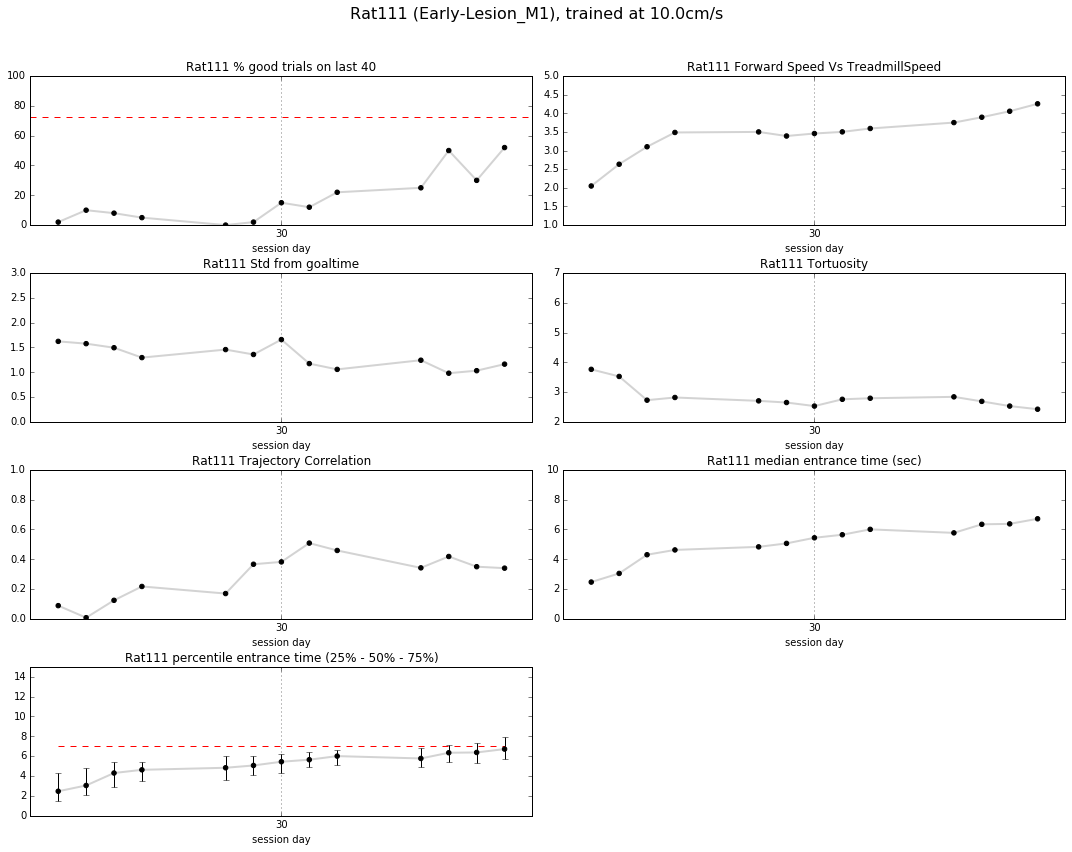

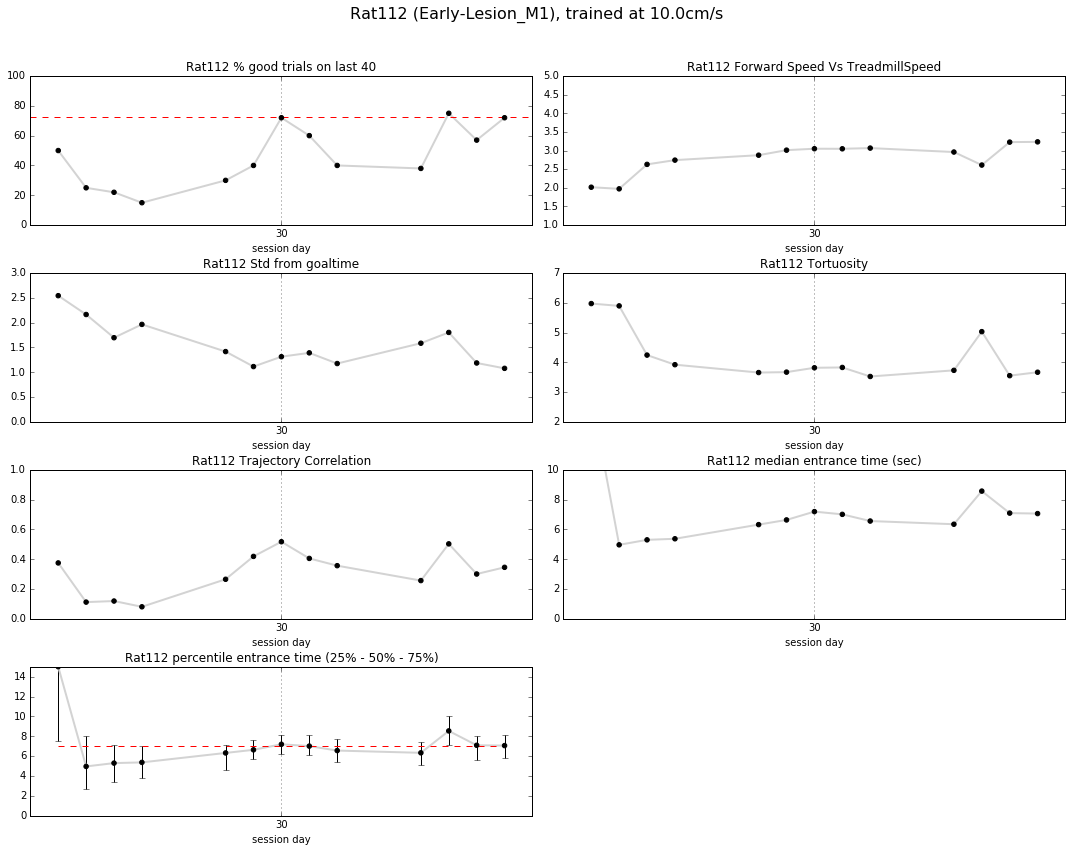

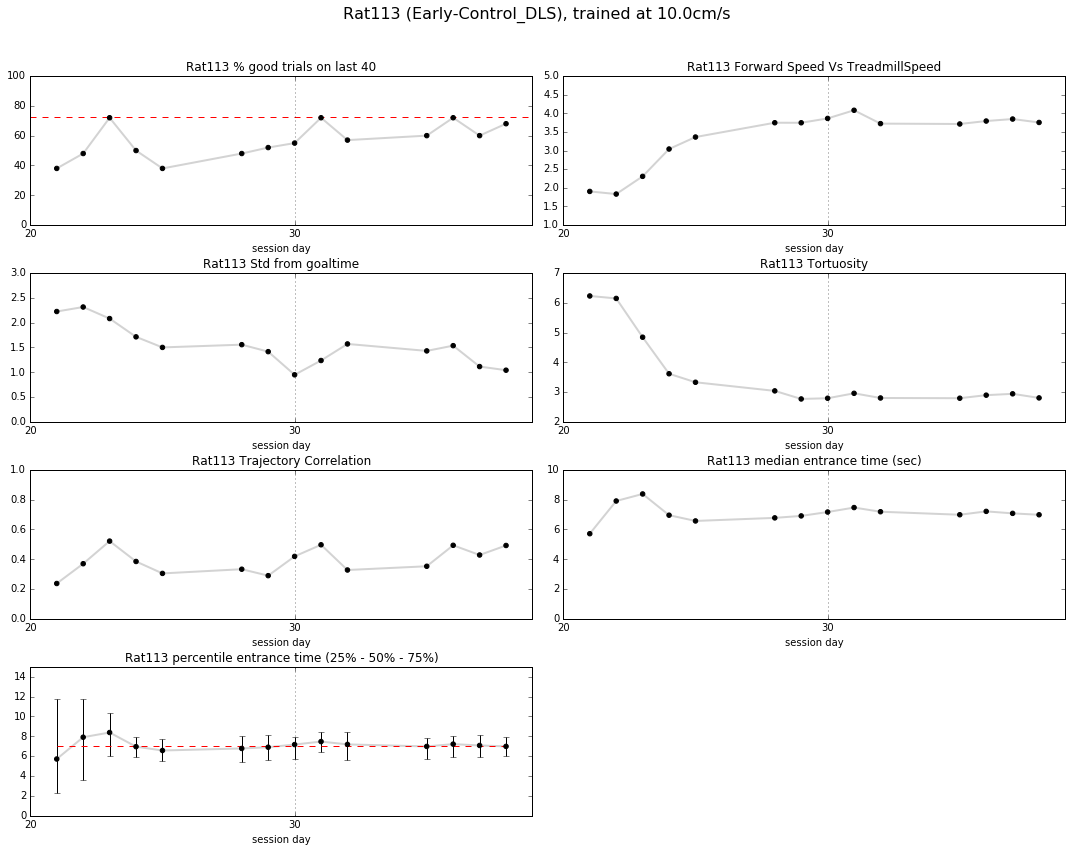

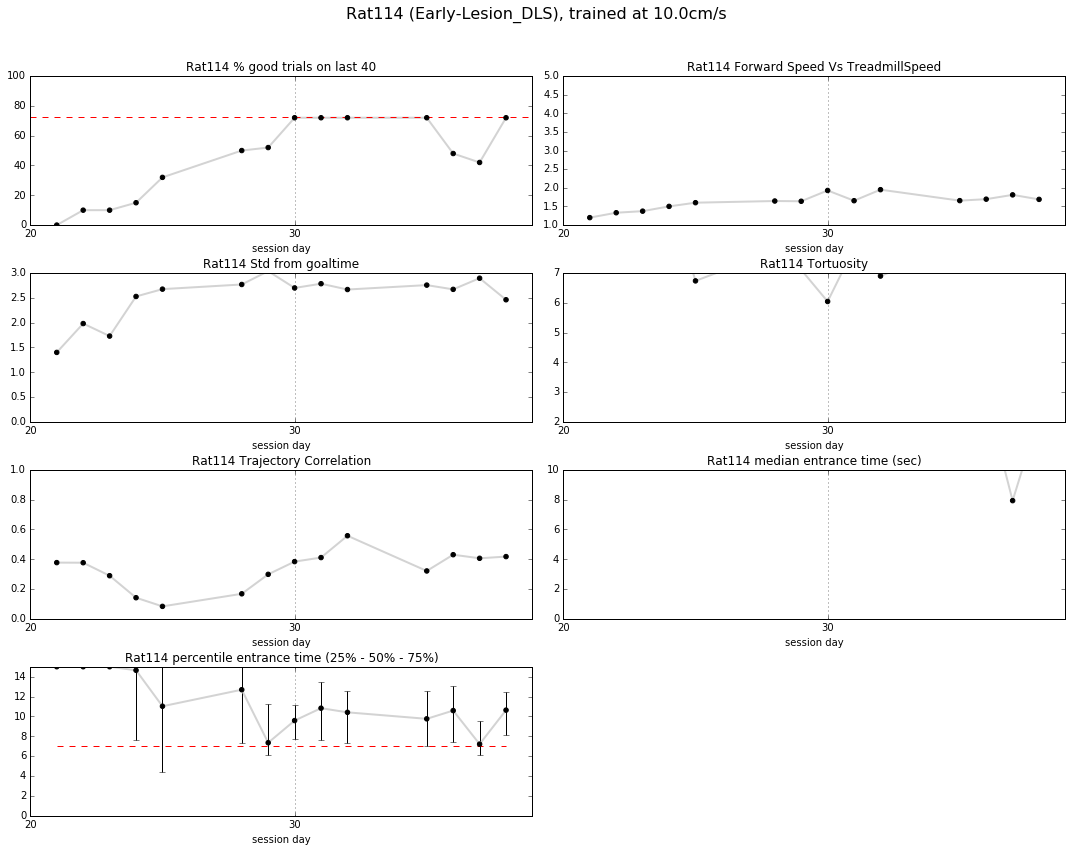

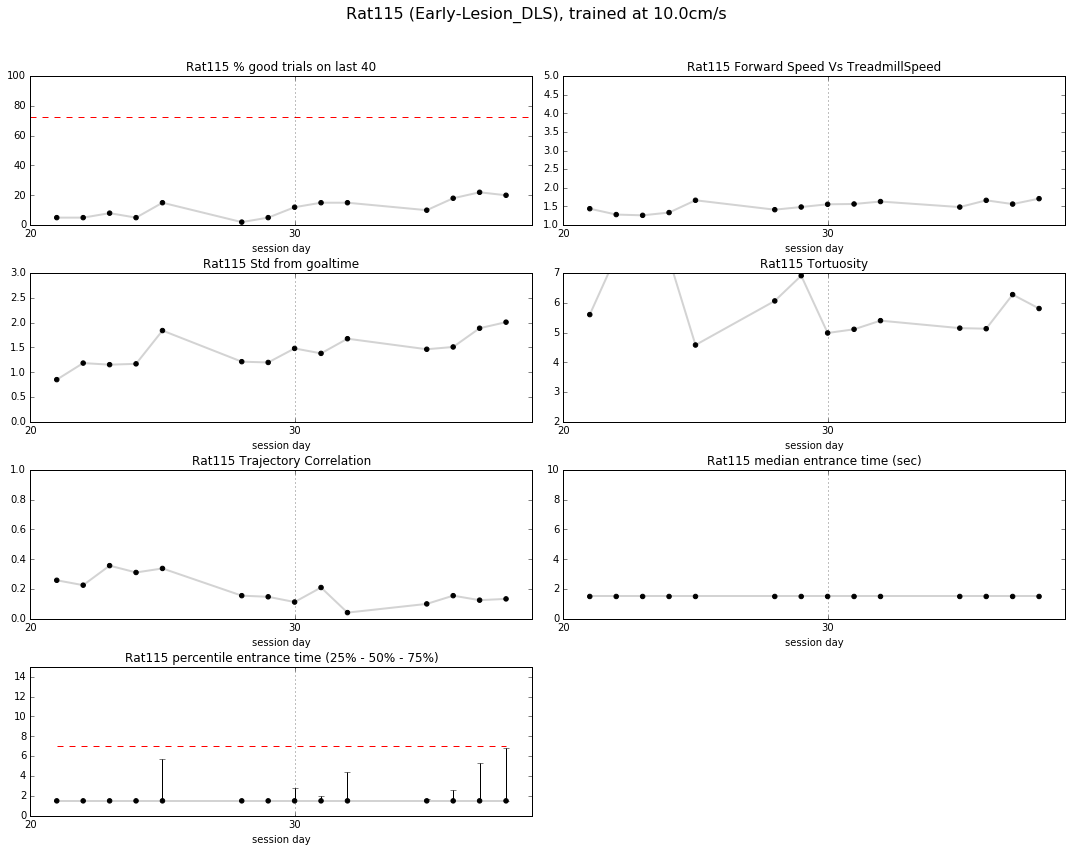

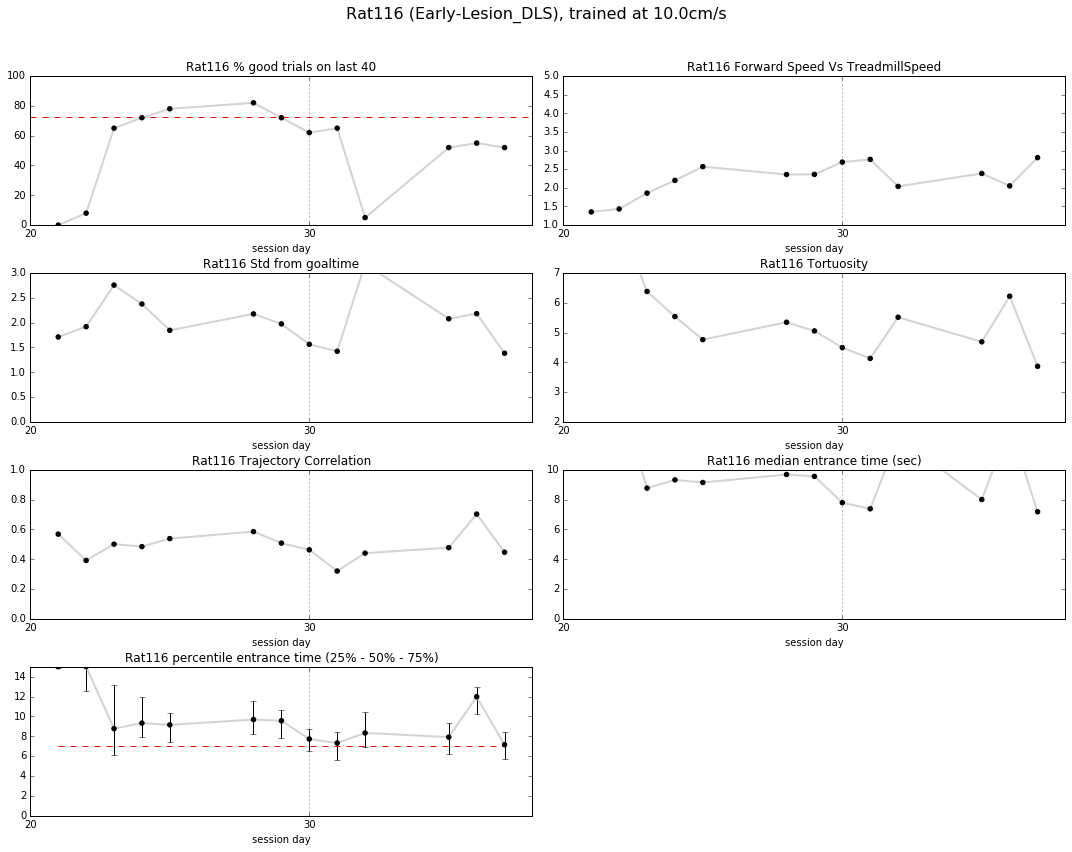

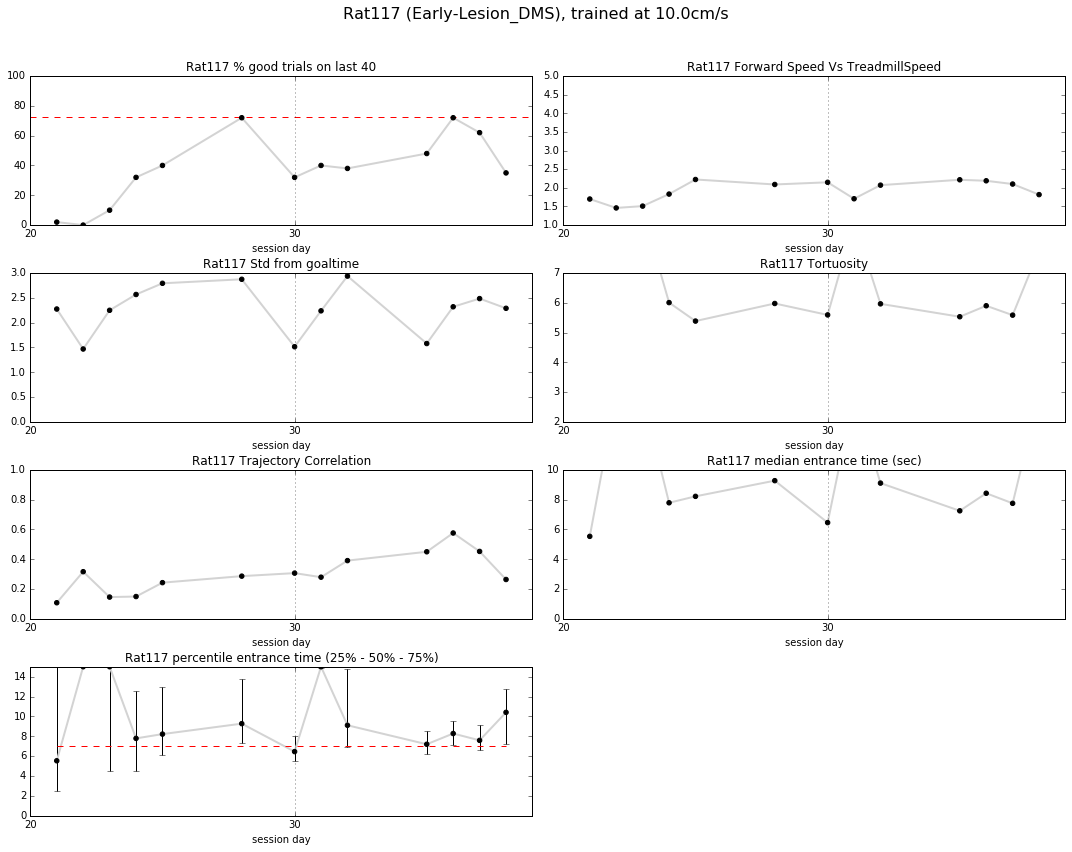

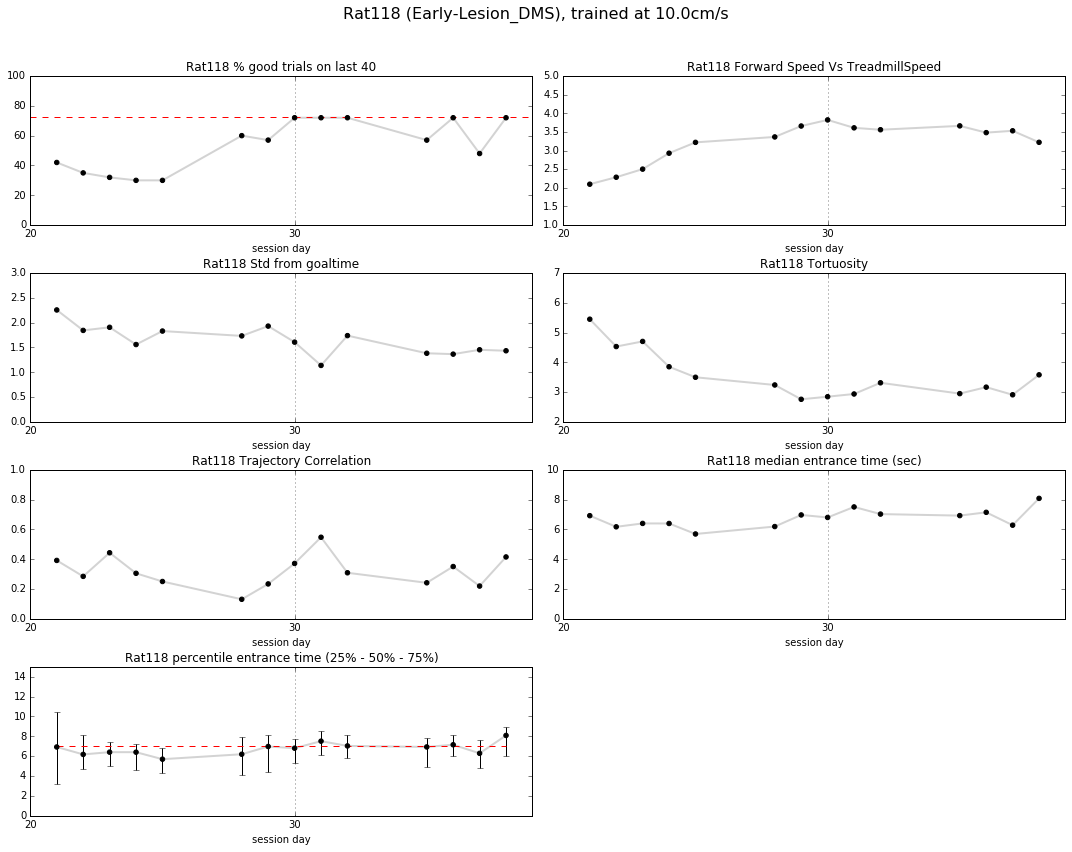

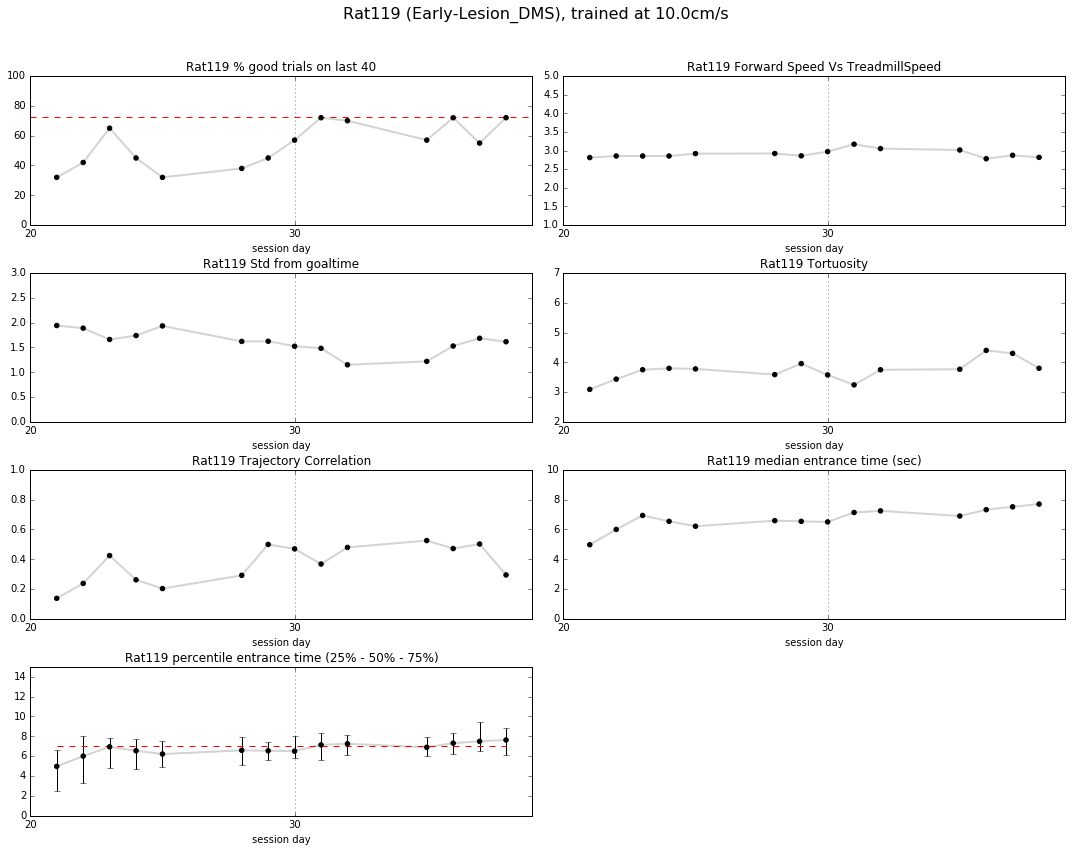

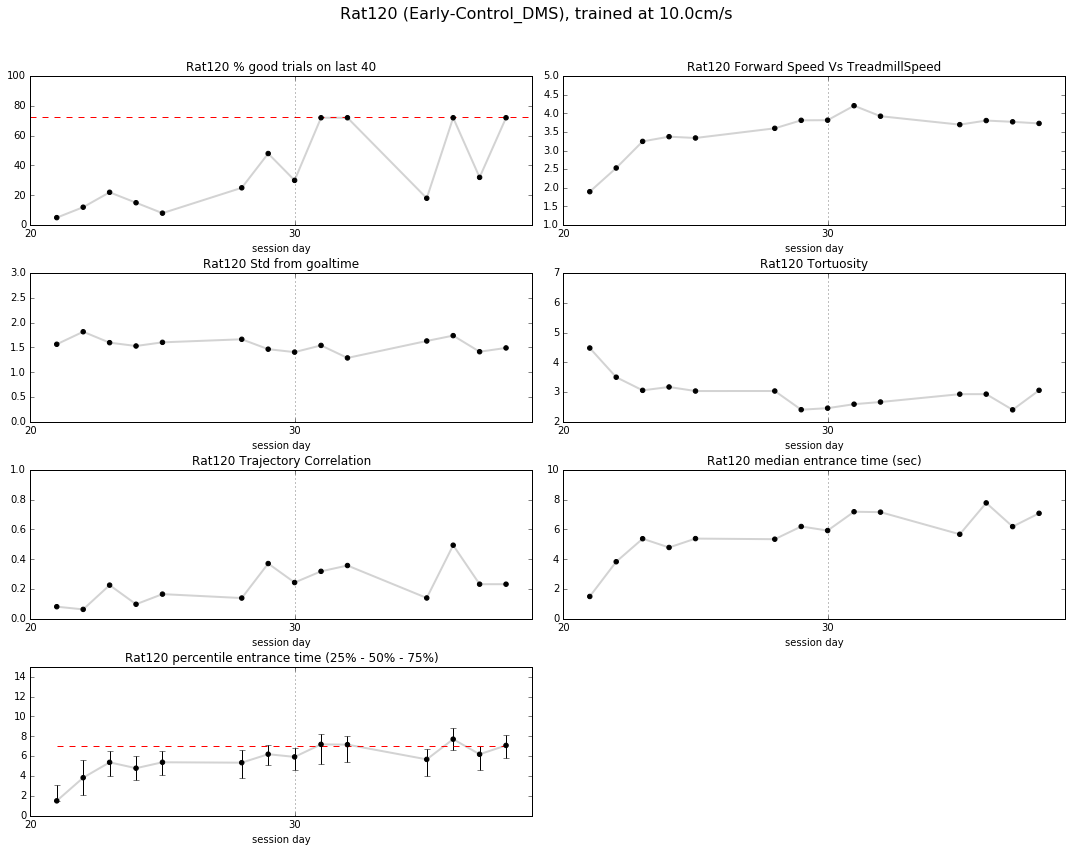

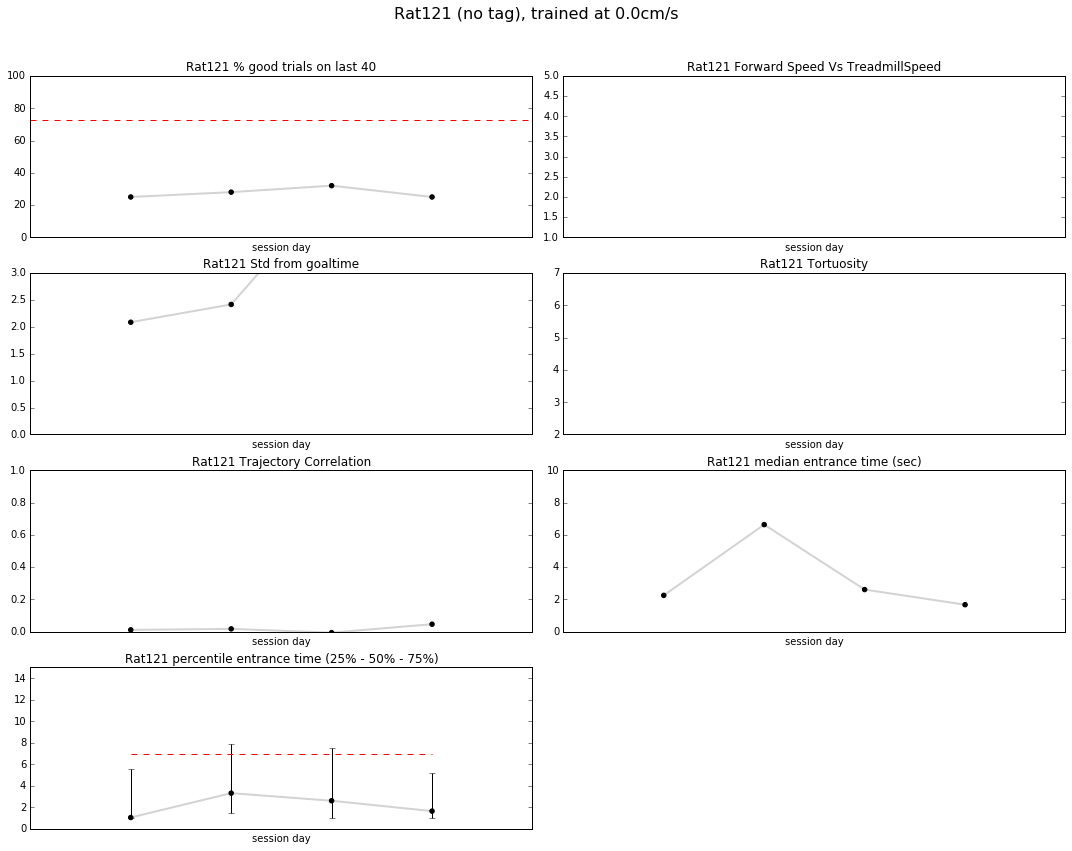

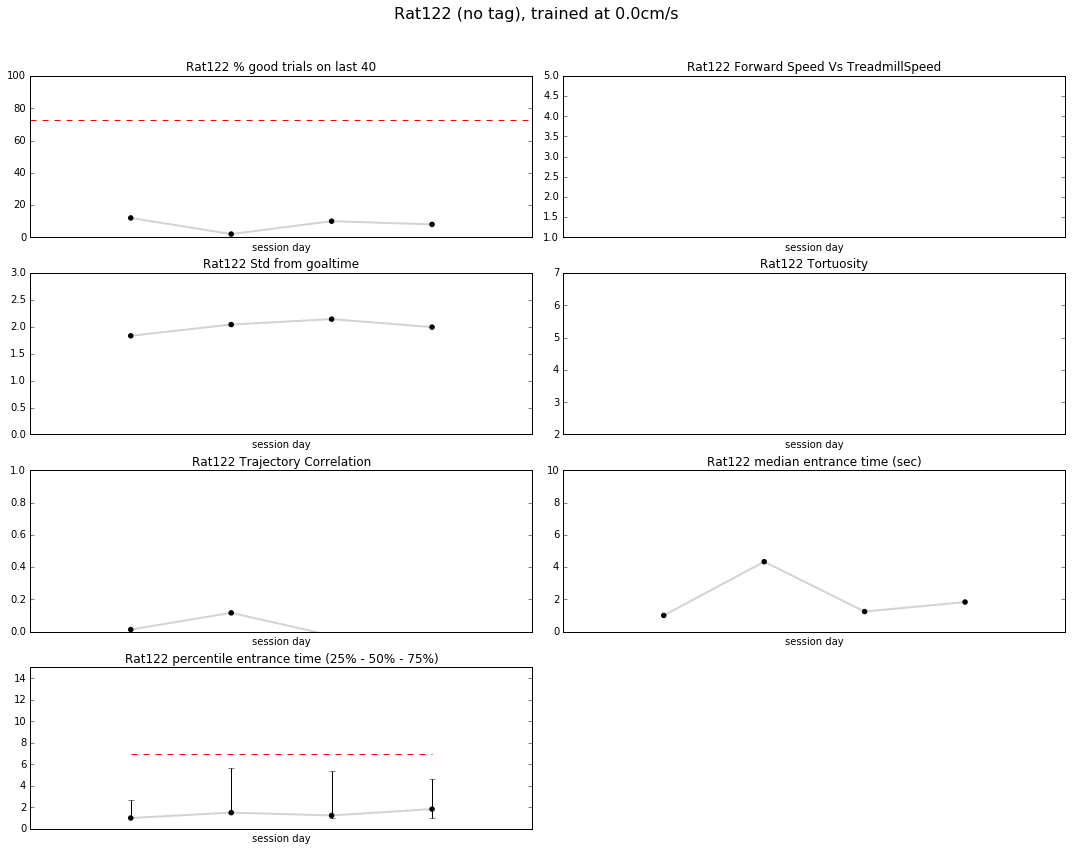

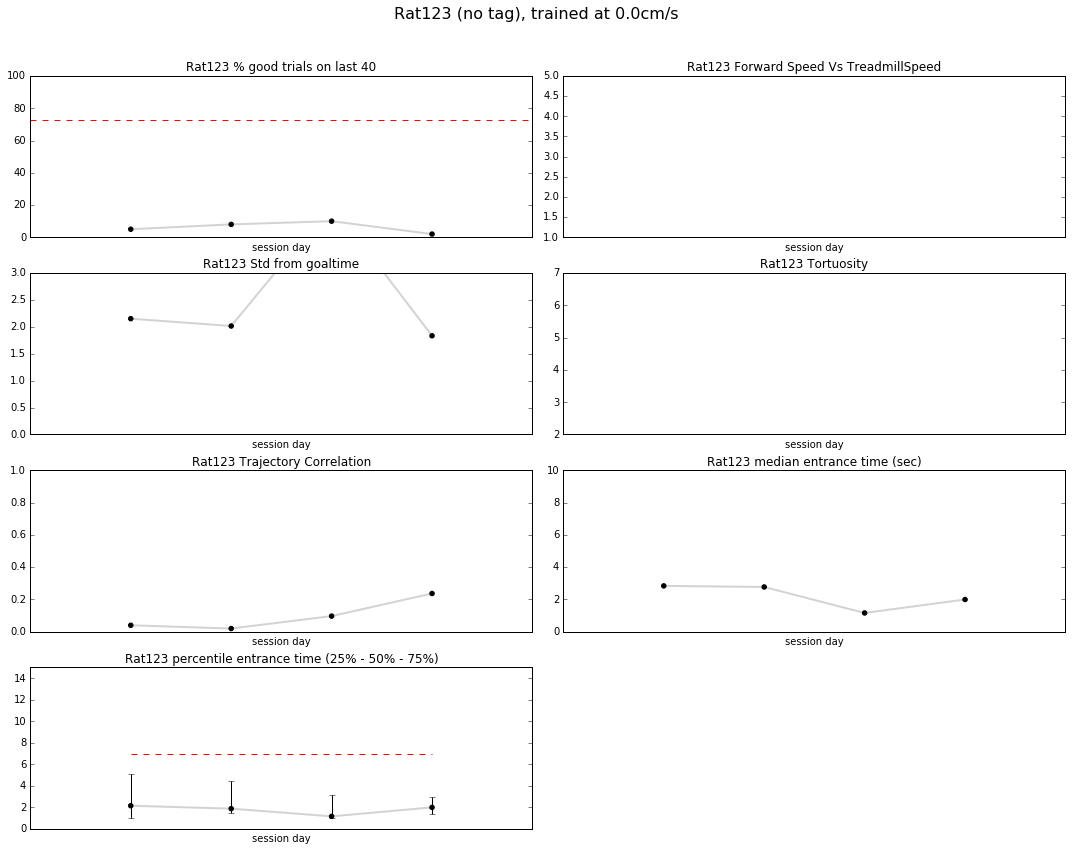

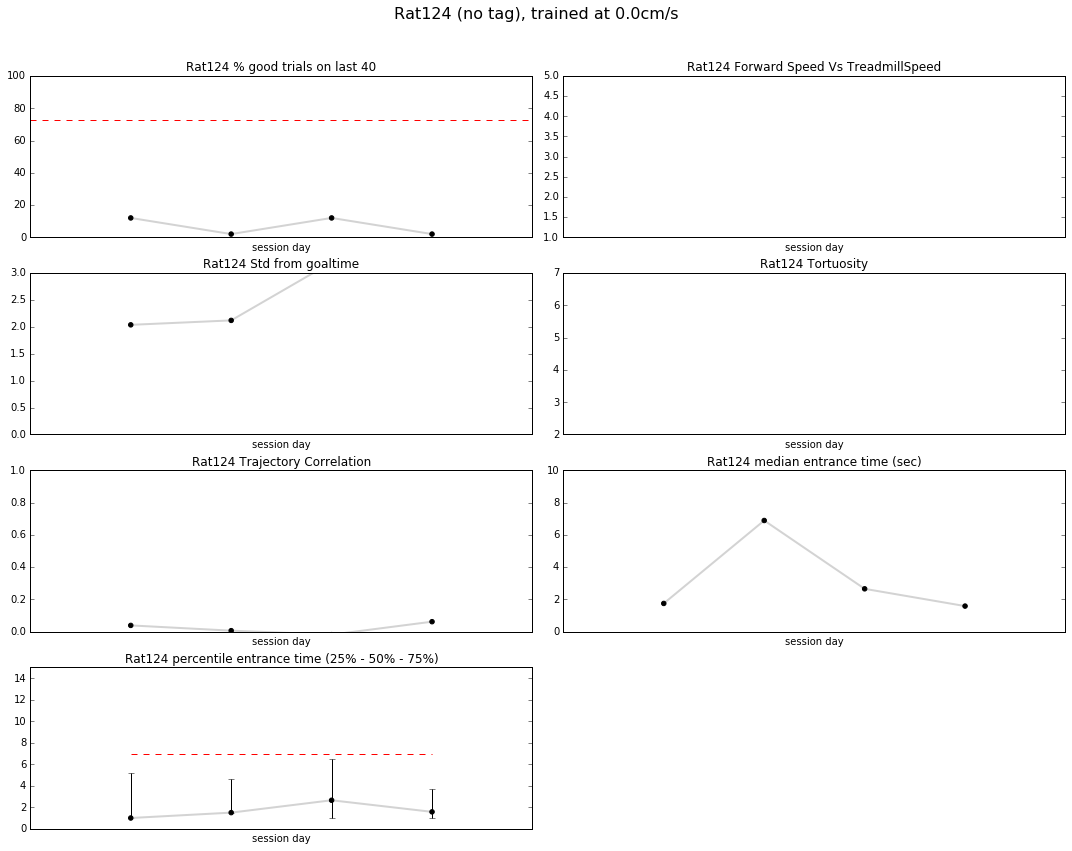

In [62]:
#===================================================================================
''' Option A: Plot functions "one plot per session"  - BEHAVIOR'''
#
# one session = one folder = one experiment
#
# A plot is done in a "plot function", either defined here or in another .py file (ex: plotData.py). 
#
# You can do several plots at once (by giving a list of "plot function").
#
# For every session, the plots are saved in *RatXXX/Experiments/RatXXX_20.../nameOfPlot.png*  
#
# An html page is created or updated: *RatXXX/Analysis/all_nameOfPlot.html*
#===================================================================================

#-------------list of plot functions to do on each session--------------------
#those functions should take as arguments: data (+ optionnal keywords arguments)
#the functions can return False (then no plot will be saved)
if "__file__" not in dir():
    
    print("List of animal to loop through: %s"%animalList)
    plotFunctionList=[plot_session_behavior]
    errorSession=[]


    #---------------------------loop on animal-------------------------------------

    for animal in animalList:
        print("Animal %s"%animal)
        print("**********")

        #----Get the list of all session
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
        sessionList=sorted(sessionList)
        nbSession=len(sessionList)


        #----If delete the general HTML file

        if replaceHtml:
            for plotFunction in plotFunctionList:
                name = str(plotFunction.__name__)

                #html for the animal
                generalName = "all_" + name
                AnalysisFolder = os.path.join(root, animal, "Analysis")
                generalPath = os.path.join(AnalysisFolder, generalName+".html")
                if os.path.exists(generalPath):
                    os.remove(generalPath)

        #----loop through sessions
        for index,session in enumerate(sessionList):
            #clear_output()
            print("Session %s/%s: %s"%(index+1,nbSession,session))

            #----------------------check for tag file-------------------------
            #if tag list is not emtpy
            if tagList:
                #check if the session has one of the tag
                if not has_tag(root, animal, session, tagList):
                    continue

            #----load data for this session (add redoPreprocess=True to overwrite preprocess)
            try:
                sessionData=Data(root,animal,session,param=param,redoPreprocess=redo,saveAsPickle=True)
            except Exception as e:
                display(HTML("<b> An error happened, skip session. Error message: </b>"))
                display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
                errorSession.append(session)
                continue            
            #----skip if training data or no break time
            if (not sessionData.hasBehavior):
                print("No Behavior, skipped")
                print("--------")
                continue
            if len(sessionData.entranceTime)==1:
                print("Only one entrance Time, skipped")
                print("--------")
                continue
            
            #---skip if file "NotToAnalyze"
            try:
                if "NotToAnalyze" in sessionData.emptyAnalysisFiles:
                    print("Not to analyze, skipped")
                    print("--------")
                    continue 
            except:
                continue
            #----plot the data (add name="myNewName" to change the name of the html, add override=True to redo the plots)
            sessionData.plot_session_png_html(plotFunctionList,override=override)
            clear_output()
            sys.stdout.flush()

        #----plot the Learning curve
        results = plot_learningCurves(root, animal,PerfParamToPlot, param, tagList=tagList,redoPreprocess=False, redoStat=False)
